In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import pinv
import statsmodels.api as sm
from scipy.optimize import minimize
import autograd.numpy as np
from autograd import grad, hessian
import matplotlib.pyplot as plt
from scipy.stats import qmc
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor

# Data Generation

### Non-linear Population Dynamics Model (Logistic Growth Model)

P_{t+1} = P_t + r * P_t * (1 - P_t / K) * noise_factor


Where:
- `P_t`: Current population at time `t`.
- `r`: Intrinsic growth rate, representing how quickly the population would grow if there were no constraints.
- `K`: Carrying capacity, or the maximum population size the environment can support.
- `noise_factor`: A term that introduces variability into the growth rate, sampled from Laplace distribution and scaled by the square root of the population at the previous timestep. This simulates natural fluctuations such as environmental changes or resource availability.




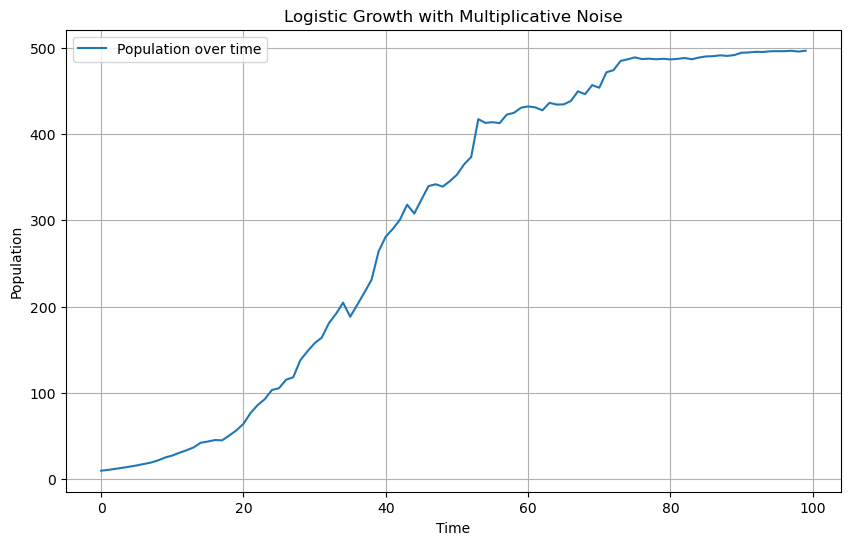

In [77]:
# Parameters
r = 0.1  # intrinsic growth rate
K = 500  # carrying capacity
time_steps = 100  # number of time steps to simulate
P_log = np.zeros(time_steps)
P_log[0] = 10  # initial population

np.random.seed(0)
# Simulate the logistic growth with multiplicative noise
for t in range(1, time_steps):
    noise_factor = np.random.laplace(loc=1, scale=0.05 * np.sqrt(P_log[t-1]))  # Laplace noise with mean 1, scale 0.5
    #noise_factor = np.random.standard_cauchy() * 0.1  # Cauchy noise with scale 0.1
    P_log[t] = P_log[t-1] + r * P_log[t-1] * (1 - P_log[t-1] / K) * noise_factor

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(P_log, label='Population over time')
plt.title('Logistic Growth with Multiplicative Noise')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# Objective function for non-linear LAD regression using logistic growth model
def lad_objective_log(params, P, time_steps):
    r, K = params
    sum_absolute_deviation = 0
    for t in range(1, time_steps):
        P_pred = P[t-1] + r * P[t-1] * (1 - P[t-1] / K)
        sum_absolute_deviation += abs(P_pred - P[t])
    return sum_absolute_deviation

### Linear Population Dynamics Model (Additive)

The population at time \( t+1 \) is given by:

P_t = r * t + K + noise

Where:
- `P_t`: Population at time `t`.
- `r`: Growth rate coefficient, indicating the increase in population per unit time.
- `K`: Base population or the intercept term, representing the initial population when `t=0`.
- `noise`: Random variation, with its standard deviation proportional to the square root of \( P_t-1 \)


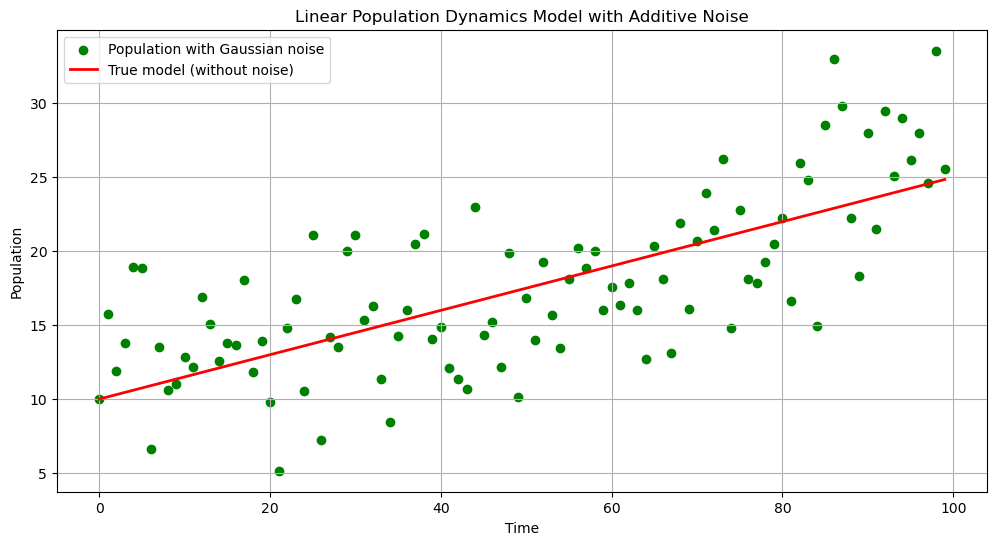

In [4]:
np.random.seed(0)

def generate_population_data_and_design_matrix(time_steps, r, K, noise_type='gaussian', base_scale=1):
    t = np.arange(time_steps)
    X = np.column_stack((np.ones(time_steps), t))
    P = r * t + K

    P_noisy = np.zeros(time_steps)
    P_noisy[0] = P[0]

    for i in range(1, time_steps):
        if noise_type == 'gaussian':
            noise = np.random.normal(loc=0, scale=base_scale * np.sqrt(P_noisy[i-1]))
        elif noise_type == 'laplace':
            noise = np.random.laplace(loc=0, scale=base_scale * np.sqrt(P_noisy[i-1]))
        elif noise_type == 'no':
            noise = 0
        else:
            raise ValueError("Unsupported noise type. Choose 'gaussian' or 'laplace' or 'no'.")

        P_noisy[i] = P[i] + noise

    return t, P_noisy, X

# Parameters for the model
r = 0.15  # Slope
K = 10    # Intercept
time_steps = 100  # Number of time points

# Generate data with Gaussian noise
t, P_gaussian, X_gaussian = generate_population_data_and_design_matrix(time_steps, r, K, noise_type='gaussian', base_scale=1)
# no noise data
t, P_no_noise, X_no_noise = generate_population_data_and_design_matrix(time_steps, r, K, noise_type='no', base_scale=1)
# 0.5 noise scale
t, P_gaussian_05, X_gaussian_05 = generate_population_data_and_design_matrix(time_steps, r, K, noise_type='gaussian', base_scale=0.5)
# 0.25 noise scale
t, P_gaussian_025, X_gaussian_025 = generate_population_data_and_design_matrix(time_steps, r, K, noise_type='gaussian', base_scale=0.25)

# True model without noise
P_true = r * t + K

# Plotting the true model and the generated data with Gaussian noise
plt.figure(figsize=(12, 6))
plt.scatter(t, P_gaussian, label='Population with Gaussian noise', color='green')
plt.plot(t, P_true, label='True model (without noise)', linewidth=2, color='red')
plt.title('Linear Population Dynamics Model with Additive Noise')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()


# Study of the objective


### Plot the shape

In [5]:
# Objective function for linear LAD regression
def lad_objective(params, P, X):
    r, K = params
    P_pred = X @ np.array([K, r])
    return np.sum(np.abs(P - P_pred))


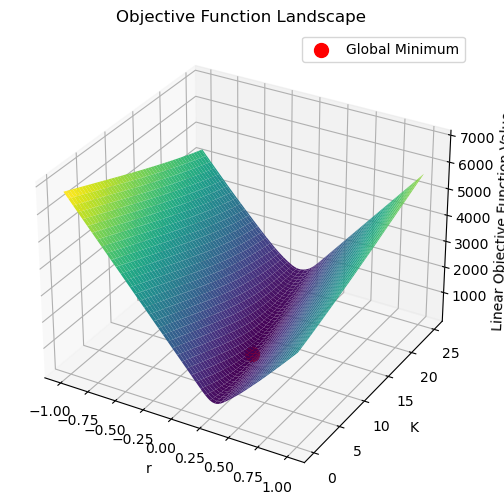

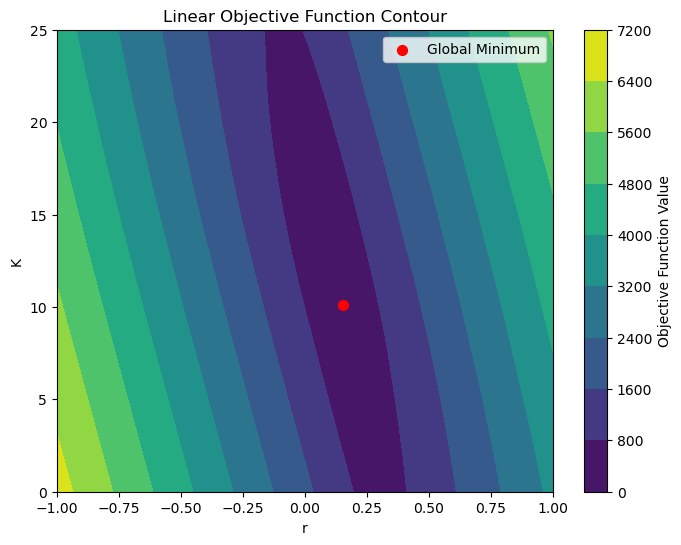

In [6]:

# Function to create a grid and evaluate the objective function
def create_objective_landscape(P, X, r_range, K_range, grid_size=100):
    r_values = np.linspace(r_range[0], r_range[1], grid_size)
    K_values = np.linspace(K_range[0], K_range[1], grid_size)
    R, K = np.meshgrid(r_values, K_values)
    Z = np.zeros_like(R)

    for i in range(grid_size):
        for j in range(grid_size):
            Z[i, j] = lad_objective([R[i, j], K[i, j]], P, X)

    return R, K, Z

# Ranges for r and K
r_range = [-1, 1]
K_range = [0, 25]
#r_range = [0.14, 0.15]
#K_range = [10, 11]
R, K, Z = create_objective_landscape(P_gaussian, X_gaussian, r_range, K_range)

# Find the global minimum
min_idx = np.unravel_index(np.argmin(Z), Z.shape)
min_r = R[min_idx]
min_K = K[min_idx]
min_value = Z[min_idx]

# Plot the 3D landscape with the minimum highlighted
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(R, K, Z, cmap='viridis')
min_dot = ax.scatter(min_r, min_K, min_value, color='r', s=100, label='Global Minimum')
ax.set_title('Objective Function Landscape')
ax.set_xlabel('r')
ax.set_ylabel('K')
ax.set_zlabel('Linear Objective Function Value')
ax.legend()
plt.show()




# Plot the 2D contour with the minimum highlighted
plt.figure(figsize=(8, 6))
contour = plt.contourf(R, K, Z, cmap='viridis')
plt.colorbar(contour, label='Objective Function Value')
plt.scatter(min_r, min_K, color='red', s=50, label='Global Minimum')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Linear Objective Function Contour')
plt.legend()
plt.show()


# Print the global minima values
#print(f'Global minimum at r = {min_r:.4f}, K = {min_K:.4f}, Objective = {min_value:.4f}')


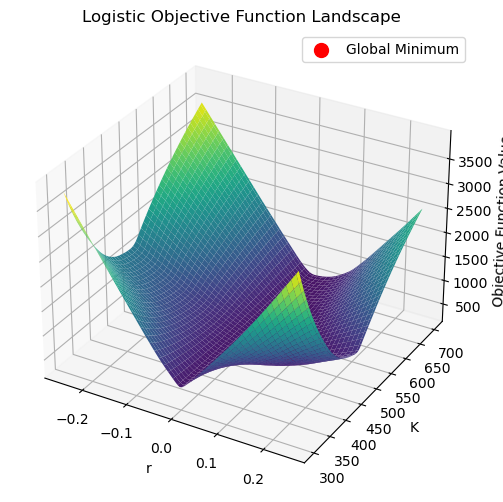

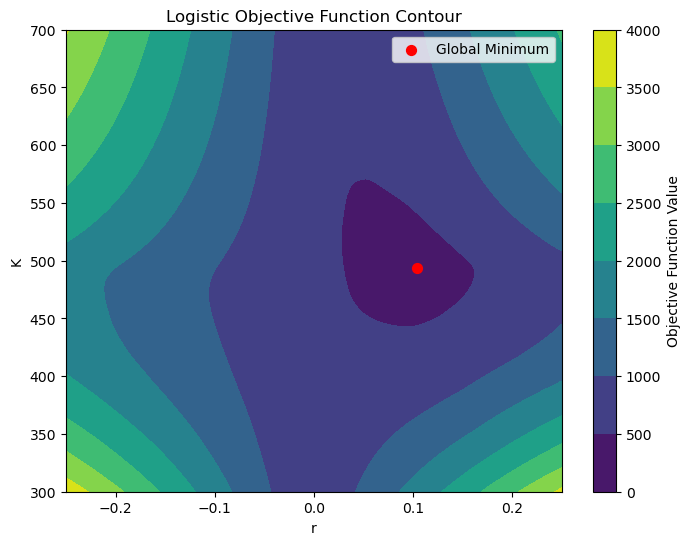

In [25]:
# Function to create a grid and evaluate the logistic objective function
def create_logistic_objective_landscape(P, time_steps, r_range, K_range, grid_size=100):
    r_values = np.linspace(r_range[0], r_range[1], grid_size)
    K_values = np.linspace(K_range[0], K_range[1], grid_size)
    R, K = np.meshgrid(r_values, K_values)
    Z = np.zeros_like(R)

    for i in range(grid_size):
        for j in range(grid_size):
            Z[i, j] = lad_objective_log([R[i, j], K[i, j]], P, time_steps)

    return R, K, Z


# Ranges for r and K
r_range = [-0.25, 0.25]
K_range = [300, 700]
#r_range = [0.09, 0.11]
#K_range = [490, 510]
R, K, Z = create_logistic_objective_landscape(P_log, time_steps, r_range, K_range)

# Find the global minimum
min_idx = np.unravel_index(np.argmin(Z), Z.shape)
min_r = R[min_idx]
min_K = K[min_idx]
min_value = Z[min_idx]

# Plot the 3D landscape with the minimum highlighted
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(R, K, Z, cmap='viridis')
min_dot = ax.scatter(min_r, min_K, min_value, color='r', s=100, label='Global Minimum')
ax.set_title('Logistic Objective Function Landscape')
ax.set_xlabel('r')
ax.set_ylabel('K')
ax.set_zlabel('Objective Function Value')
ax.legend()
plt.show()

# Plot the 2D contour with the minimum highlighted
plt.figure(figsize=(8, 6))
contour = plt.contourf(R, K, Z, cmap='viridis')
plt.colorbar(contour, label='Objective Function Value')
plt.scatter(min_r, min_K, color='red', s=50, label='Global Minimum')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Logistic Objective Function Contour')
plt.legend()
plt.show()



# Print the global minima values
#print(f'Global minimum at r = {min_r:.4f}, K = {min_K:.4f}, Objective = {min_value:.4f}')


#### Find plateau regions on the log objective

In [79]:
# Gradient function for the logistic objective
grad_lad_objective_log = grad(lad_objective_log)

# Function to evaluate the objective and gradient at a given point
def evaluate_point(i, j, R, K, P, time_steps):
    params = [R[i, j], K[i, j]]
    Z_value = lad_objective_log(params, P, time_steps)
    grads = grad_lad_objective_log(params, P, time_steps)
    grad_magnitude_value = np.linalg.norm(grads)
    return i, j, Z_value, grad_magnitude_value

# Function to create a grid and evaluate the logistic objective function using multithreading
def create_logistic_objective_landscape(P, time_steps, r_range, K_range, grid_size=1000):
    r_values = np.linspace(r_range[0], r_range[1], grid_size)
    K_values = np.linspace(K_range[0], K_range[1], grid_size)
    R, K = np.meshgrid(r_values, K_values)
    Z = np.zeros_like(R)
    grad_magnitude = np.zeros_like(R)

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(evaluate_point, i, j, R, K, P, time_steps) for i in range(grid_size) for j in range(grid_size)]
        for future in futures:
            i, j, Z_value, grad_magnitude_value = future.result()
            Z[i, j] = Z_value
            grad_magnitude[i, j] = grad_magnitude_value

    return R, K, Z, grad_magnitude

# Function to identify plateau regions
def identify_plateaus(grad_magnitude, threshold=1.0):
    return grad_magnitude < threshold

# Parameters
r_range = [-0.25, 0.25]
K_range = [300, 700]

# Create the logistic objective landscape
R, K, Z, grad_magnitude = create_logistic_objective_landscape(P_log, time_steps, r_range, K_range)

# Find the global minimum
min_idx = np.unravel_index(np.argmin(Z), Z.shape)
min_r = R[min_idx]
min_K = K[min_idx]
min_value = Z[min_idx]

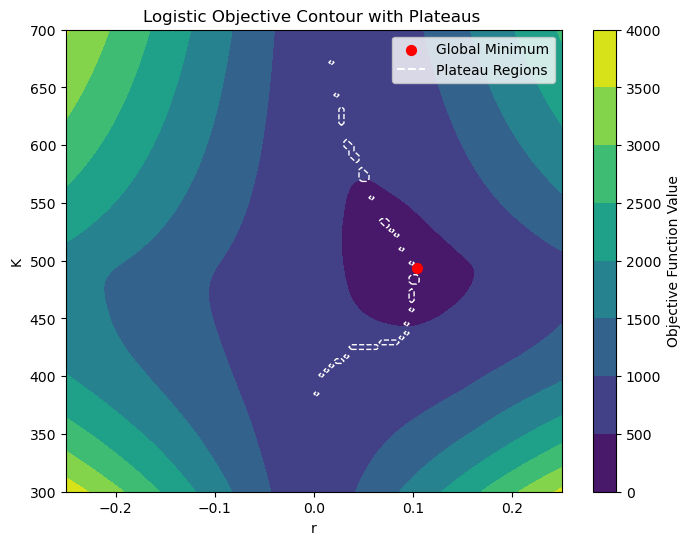

In [80]:

# Identify plateau regions
plateau_regions = identify_plateaus(grad_magnitude, threshold=100.0)

# Plot the 2D contour with the minimum and plateau regions highlighted
plt.figure(figsize=(8, 6))
contour = plt.contourf(R, K, Z, cmap='viridis')
plt.colorbar(contour, label='Objective Function Value')
plt.scatter(min_r, min_K, color='red', s=50, label='Global Minimum')
plt.contour(R, K, plateau_regions, colors='white', linewidths=1, linestyles='dashed')
plt.plot([], [], 'w--', label='Plateau Regions')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Logistic Objective Contour with Plateaus ')
plt.legend()
plt.show()

### Finite difference to determine weather the bottom is sharp

In [6]:
def finite_difference_gradient(params, P, X, h=0.001):
    r, K = params
    fr_plus_h = lad_objective([r + h, K], P, X)
    fr_minus_h = lad_objective([r - h, K], P, X)
    fK_plus_h = lad_objective([r, K + h], P, X)
    fK_minus_h = lad_objective([r, K - h], P, X)

    gradient_r = (fr_plus_h - fr_minus_h) / (2 * h)
    gradient_K = (fK_plus_h - fK_minus_h) / (2 * h)

    return np.array([gradient_r, gradient_K])

# Select a range of points around the estimated minimum to analyze
r = 0.15
K = 10
"""
points = [(r + dr, K + dK) for dr in np.linspace(-0.05, 0.05, 5)
          for dK in np.linspace(-5, 5, 5)]
"""
points = [(r + dr, K + dK) for dr in np.linspace(-0.01, 0.01, 5)
          for dK in np.linspace(-1, 1, 5)]



# Calculate and print gradients at each point
for point in points:
    grad = finite_difference_gradient(point, P_gaussian, X_gaussian)
    print(f"Gradient at r = {point[0]}, K = {point[1]}: {grad}")

Gradient at r = 0.13999999999999999, K = 9.0: [-1404.   -34.]
Gradient at r = 0.13999999999999999, K = 9.5: [-817.89345291  -22.        ]
Gradient at r = 0.13999999999999999, K = 10.0: [-450.  -11.]
Gradient at r = 0.13999999999999999, K = 10.5: [-287.75681756   -6.        ]
Gradient at r = 0.13999999999999999, K = 11.0: [197.02412226   4.        ]
Gradient at r = 0.145, K = 9.0: [-1108.89345291   -30.        ]
Gradient at r = 0.145, K = 9.5: [-613.40905266  -16.        ]
Gradient at r = 0.145, K = 10.0: [-450.  -11.]
Gradient at r = 0.145, K = 10.5: [-218.04655911   -6.        ]
Gradient at r = 0.145, K = 11.0: [694.45158238  14.        ]
Gradient at r = 0.15, K = 9.0: [-806.77137394  -24.        ]
Gradient at r = 0.15, K = 9.5: [-468.  -14.]
Gradient at r = 0.15, K = 10.0: [-298.57527809   -9.        ]
Gradient at r = 0.15, K = 10.5: [350.   4.]
Gradient at r = 0.15, K = 11.0: [978.  16.]
Gradient at r = 0.155, K = 9.0: [-676.  -22.]
Gradient at r = 0.155, K = 9.5: [-441.57527809  -1

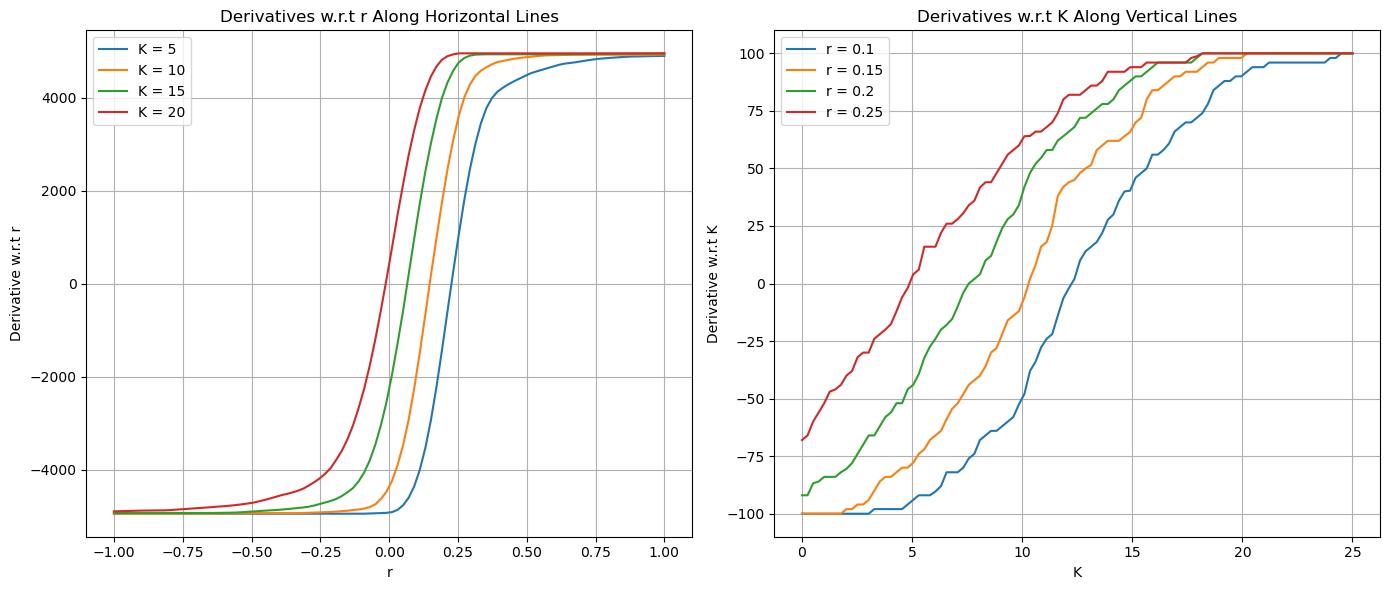

In [7]:
def derivative_r(P, X, r, K, h=0.1):
    """Calculate the approximate derivative with respect to r at a given r, K."""
    return (lad_objective([r + h, K], P, X) - lad_objective([r - h, K], P, X)) / (2 * h)

def derivative_K(P, X, r, K, h=0.01):
    """Calculate the approximate derivative with respect to K at a given r, K."""
    return (lad_objective([r, K + h], P, X) - lad_objective([r, K - h], P, X)) / (2 * h)

# Define ranges and steps
r_values = np.linspace(-1, 1, 100)  # step 0.02
K_values = np.linspace(0, 25, 100)  # step 0.25
K_lines = [5, 10, 15, 20]
r_lines = [0.1, 0.15, 0.2, 0.25]

# Plotting derivatives with respect to r
plt.figure(figsize=(14, 6))

# Plot 1: Derivatives along horizontal lines
plt.subplot(1, 2, 1)
for K in K_lines:
    derivatives_r = [derivative_r(P_gaussian, X_gaussian, r, K) for r in r_values]
    plt.plot(r_values, derivatives_r, label=f'K = {K}')
plt.title('Derivatives w.r.t r Along Horizontal Lines')
plt.xlabel('r')
plt.ylabel('Derivative w.r.t r')
plt.legend()
plt.grid(True)

# Plot 2: Derivatives along vertical lines
plt.subplot(1, 2, 2)
for r in r_lines:
    derivatives_K = [derivative_K(P_gaussian, X_gaussian, r, K) for K in K_values]
    plt.plot(K_values, derivatives_K, label=f'r = {r}')
plt.title('Derivatives w.r.t K Along Vertical Lines')
plt.xlabel('K')
plt.ylabel('Derivative w.r.t K')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Autodiff

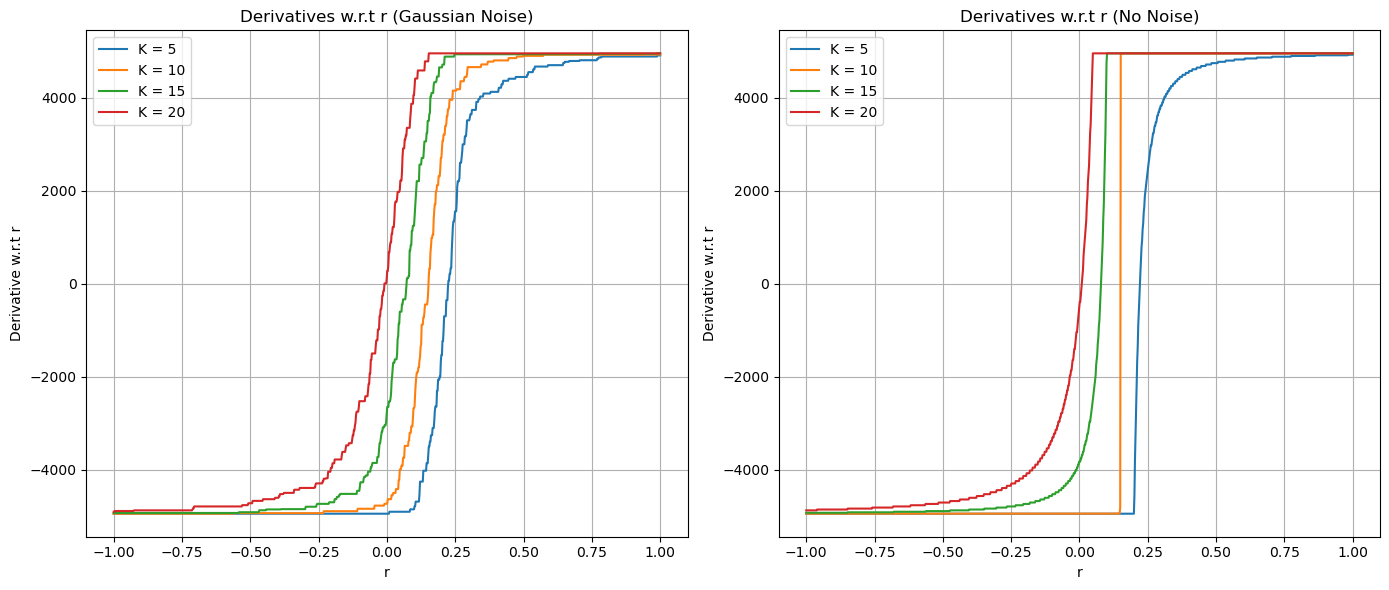

In [7]:
# Autodiff

# Define the gradient functions
grad_lad_r = grad(lambda params, P, X: lad_objective(params, P, X), 0)

# Function to compute gradients along r and K
def compute_gradients(P, X, r_values, K_values):
    gradients_r = np.zeros((len(r_values), len(K_values)))
    gradients_K = np.zeros((len(r_values), len(K_values)))
    for i, r in enumerate(r_values):
        for j, K in enumerate(K_values):
            grad_r = grad_lad_r([float(r), float(K)], P, X)[0]
            grad_K = grad_lad_r([float(r), float(K)], P, X)[1]
            gradients_r[i, j] = grad_r
            gradients_K[i, j] = grad_K
    return gradients_r, gradients_K

# Define ranges for r and K
r_values = np.linspace(-1, 1, 1000)
K_values = np.linspace(0, 25, 1000)
K_lines = [5, 10, 15, 20]

# Compute gradients for both datasets
gradients_r_gaussian, _ = compute_gradients(P_gaussian, X_gaussian, r_values, K_values)
gradients_r_no_noise, _ = compute_gradients(P_no_noise, X_no_noise, r_values, K_values)

# Find the closest indices in K_values for the specific lines
K_indices = [np.abs(K_values - K).argmin() for K in K_lines]

# Plotting derivatives with respect to r for both datasets
plt.figure(figsize=(14, 6))

# Plot 1: Derivatives for P_gaussian
plt.subplot(1, 2, 1)
for K_index, K in zip(K_indices, K_lines):
    plt.plot(r_values, gradients_r_gaussian[:, K_index], label=f'K = {K}')
plt.title('Derivatives w.r.t r (Linear, Gaussian Noise)')
plt.xlabel('r')
plt.ylabel('Derivative w.r.t r')
plt.legend()
plt.grid(True)

# Plot 2: Derivatives for P_no_noise
plt.subplot(1, 2, 2)
for K_index, K in zip(K_indices, K_lines):
    plt.plot(r_values, gradients_r_no_noise[:, K_index], label=f'K = {K}')
plt.title('Derivatives w.r.t r (Linear, No Noise)')
plt.xlabel('r')
plt.ylabel('Derivative w.r.t r')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

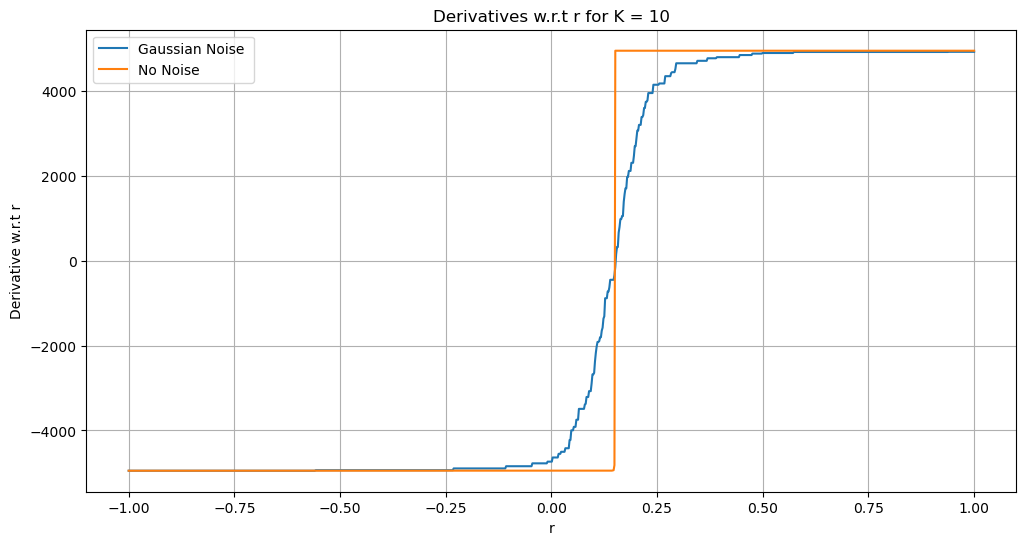

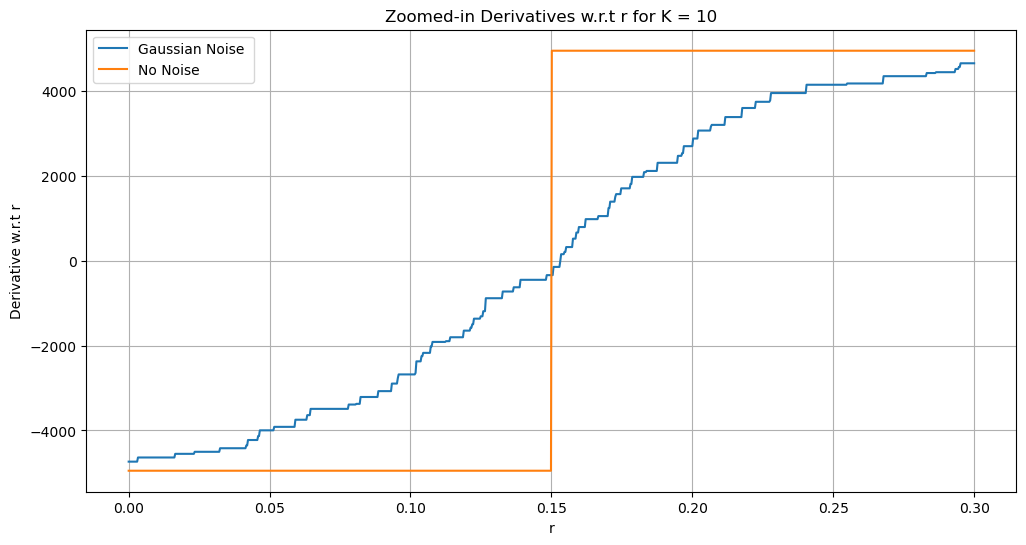

Gradient values with respect to r for K = 10 (Gaussian Noise ):
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4736.0000
r = 0.00, grad_r = -4638.0000
r = 0.00, grad_r = -4638.0000
r = 0.00, grad_r = -4638.0000
r = 0.00, grad_r = -4638.0000
r = 0.00, grad_r = -4638.0000
r = 0.00, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.01, grad_r = -4638.0000
r = 0.

In [76]:
# Find the closest index in K_values for K = 10
K_index = np.abs(K_values - 10).argmin()

# Plotting derivatives with respect to r for K = 10 for both datasets
plt.figure(figsize=(12, 6))
plt.plot(r_values, gradients_r_gaussian[:, K_index], label='Gaussian Noise ')
plt.plot(r_values, gradients_r_no_noise[:, K_index], label='No Noise')
plt.title('Derivatives w.r.t r for K = 10')
plt.xlabel('r')
plt.ylabel('Derivative w.r.t r')
plt.legend()
plt.grid(True)
plt.show()

# Zoomed-in plot around the optima
r_zoomed_values = np.linspace(0, 0.3, 1000)


# Compute gradients for zoomed-in range
gradients_r_gaussian_zoomed, _ = compute_gradients(P_gaussian, X_gaussian, r_zoomed_values, [10])
gradients_r_no_noise_zoomed, _ = compute_gradients(P_no_noise, X_no_noise, r_zoomed_values, [10])

plt.figure(figsize=(12, 6))
plt.plot(r_zoomed_values, gradients_r_gaussian_zoomed[:, 0], label='Gaussian Noise ')
plt.plot(r_zoomed_values, gradients_r_no_noise_zoomed[:, 0], label='No Noise')
plt.title('Zoomed-in Derivatives w.r.t r for K = 10')
plt.xlabel('r')
plt.ylabel('Derivative w.r.t r')
plt.legend()
plt.grid(True)
plt.show()

# Print the gradient values
print("Gradient values with respect to r for K = 10 (Gaussian Noise ):")
for r, grad_r in zip(r_zoomed_values, gradients_r_gaussian_zoomed[:, 0]):
    print(f"r = {r:.2f}, grad_r = {grad_r:.4f}")

print("\nGradient values with respect to r for K = 10 (No Noise):")
for r, grad_r in zip(r_zoomed_values, gradients_r_no_noise_zoomed[:, 0]):
    print(f"r = {r:.2f}, grad_r = {grad_r:.4f}")

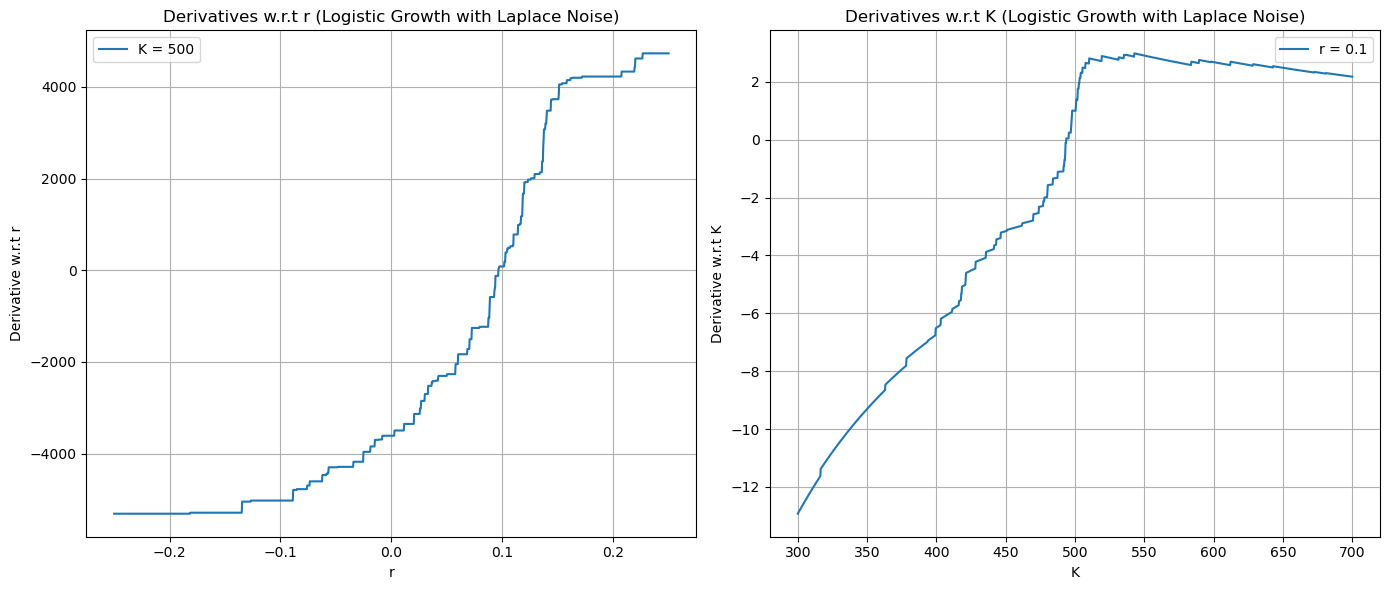

In [267]:
# Define the gradient function for the logistic growth LAD objective with respect to r

grad_lad_log_r = grad(lad_objective_log, 0)

# Function to compute gradients with respect to r for a fixed K
def compute_logistic_gradients_r(P, time_steps, r_values, fixed_K):
    def compute_gradient(r):
        return grad_lad_log_r([float(r), float(fixed_K)], np.array(P, dtype=float), int(time_steps))[0]

    gradients_r = Parallel(n_jobs=-1)(delayed(compute_gradient)(r) for r in r_values)
    return np.array(gradients_r)

# Define ranges for r
r_values = np.linspace(-0.25, 0.25, 1500)
fixed_K = 500

# Compute gradients with respect to r for the logistic growth data
gradients_r_logistic = compute_logistic_gradients_r(P_log, time_steps, r_values, fixed_K)


# Define the gradient function for the logistic growth LAD objective with respect to K
grad_lad_log_K = grad(lad_objective_log, 0)

# Function to compute gradients with respect to K for a fixed r
def compute_logistic_gradients_K(P, time_steps, fixed_r, K_values):
    def compute_gradient(K):
        return grad_lad_log_K([float(fixed_r), float(K)], np.array(P, dtype=float), int(time_steps))[1]

    gradients_K = Parallel(n_jobs=-1)(delayed(compute_gradient)(K) for K in K_values)
    return np.array(gradients_K)

# Define ranges for K
K_values = np.linspace(300, 700, 1500)
fixed_r = 0.1

# Compute gradients with respect to K for the logistic growth data
gradients_K_logistic = compute_logistic_gradients_K(P_log, time_steps, fixed_r, K_values)


# Plotting derivatives with respect to r and K for the logistic growth model
plt.figure(figsize=(14, 6))

# Plot 1: Derivatives with respect to r for a fixed K
plt.subplot(1, 2, 1)
plt.plot(r_values, gradients_r_logistic, label=f'K = {fixed_K}')
plt.title('Derivatives w.r.t r (Logistic, Laplace Noise)')
plt.xlabel('r')
plt.ylabel('Derivative w.r.t r')
plt.legend()
plt.grid(True)

# Plot 2: Derivatives with respect to K for a fixed r
plt.subplot(1, 2, 2)
plt.plot(K_values, gradients_K_logistic, label=f'r = {fixed_r}')
plt.title('Derivatives w.r.t K (Logistic, Laplace Noise)')
plt.xlabel('K')
plt.ylabel('Derivative w.r.t K')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### Is the objective differentiable (smooth) at the global minimum?

Gradients at the local minimum: [98.  2.]


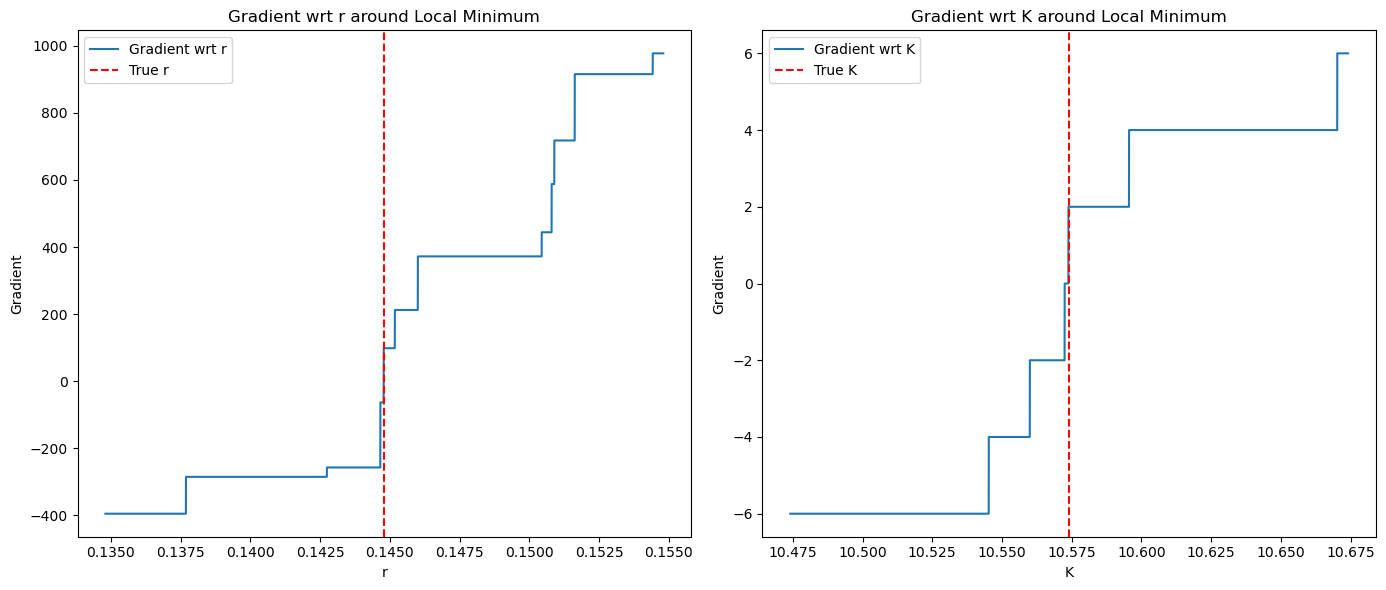

In [219]:
# Linear case

grad_lad_objective = grad(lad_objective)

# Known local minima
local_min_r = 0.1448
local_min_K = 10.5741

# Analyze smoothness around the local minima
epsilon_r = 1e-2
epsilon_K = 1e-1
params_min = np.array([local_min_r, local_min_K])
grads_at_min = grad_lad_objective(params_min, P_gaussian, X_gaussian)

print(f"Gradients at the local minimum: {grads_at_min}")

# Perturb the parameters slightly to check gradients around the minimum
r_values = np.linspace(local_min_r - epsilon_r, local_min_r + epsilon_r, 5000)
K_values = np.linspace(local_min_K - epsilon_K, local_min_K + epsilon_K, 5000)
grad_values_r = [grad_lad_objective([r, local_min_K], P_gaussian, X_gaussian)[0] for r in r_values]
grad_values_K = [grad_lad_objective([local_min_r, K], P_gaussian, X_gaussian)[1] for K in K_values]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(r_values, grad_values_r, label='Gradient wrt r')
plt.axvline(x=local_min_r, color='r', linestyle='--', label='True r')
plt.xlabel('r')
plt.ylabel('Gradient')
plt.title('Gradient wrt r around Local Minimum')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(K_values, grad_values_K, label='Gradient wrt K')
plt.axvline(x=local_min_K, color='r', linestyle='--', label='True K')
plt.xlabel('K')
plt.ylabel('Gradient')
plt.title('Gradient wrt K around Local Minimum')
plt.legend()

plt.tight_layout()
plt.show()


Gradients at the local minimum: [-8.19674228  0.04486311]


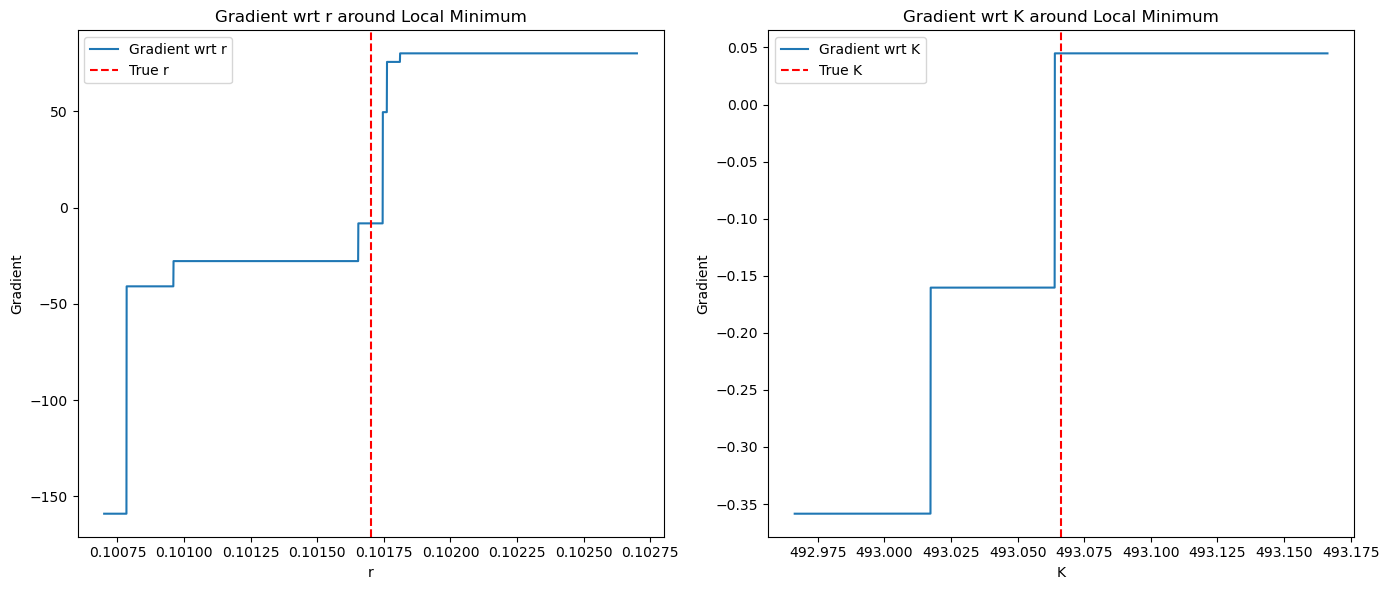

In [222]:
# Non-linear (log) case

grad_lad_objective_log = grad(lad_objective_log)

# Known local minima
local_min_r_log = 0.1017
local_min_K_log = 493.0663

# Analyze smoothness around the local minima
epsilon_r = 1e-3
epsilon_K = 1e-1
params_min = np.array([local_min_r_log, local_min_K_log])
grads_at_min = grad_lad_objective_log(params_min, P_log, time_steps)

print(f"Gradients at the local minimum: {grads_at_min}")

# Perturb the parameters slightly to check gradients around the minimum
r_values = np.linspace(local_min_r_log - epsilon_r, local_min_r_log + epsilon_r, 5000)
K_values = np.linspace(local_min_K_log - epsilon_K, local_min_K_log + epsilon_K, 5000)
grad_values_r = [grad_lad_objective_log([r, local_min_K_log], P_log, time_steps)[0] for r in r_values]
grad_values_K = [grad_lad_objective_log([local_min_r_log, K], P_log, time_steps)[1] for K in K_values]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(r_values, grad_values_r, label='Gradient wrt r')
plt.axvline(x=local_min_r_log, color='r', linestyle='--', label='True r')
plt.xlabel('r')
plt.ylabel('Gradient')
plt.title('Gradient wrt r around Local Minimum')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(K_values, grad_values_K, label='Gradient wrt K')
plt.axvline(x=local_min_K_log, color='r', linestyle='--', label='True K')
plt.xlabel('K')
plt.ylabel('Gradient')
plt.title('Gradient wrt K around Local Minimum')
plt.legend()

plt.tight_layout()
plt.show()


 # Evaluation Metrics

In [18]:
# Compare results true coefficients

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# Median Absolute Deviation
def medad(y_true, y_pred):
    return np.median(np.abs(y_true - y_pred))

# Breakdown Point
def breakdown_point(y_true, y_pred):
    """
    The breakdown point is the proportion of the largest set of outliers that an estimator can handle before giving an arbitrarily large result.
    """
    n = len(y_true)
    absolute_errors = np.abs(y_true - y_pred)
    sorted_errors = np.sort(absolute_errors)
    median_error = np.median(absolute_errors)

    # We check the proportion of errors that are not more than twice the median error
    unacceptable_level = 2 * median_error
    breakdown_index = np.argmax(sorted_errors > unacceptable_level)

    if breakdown_index == 0 and sorted_errors[0] <= unacceptable_level:
        return 1.0

    return breakdown_index / n


# Classical DFO algorithms

### Nelder-Mead

In [8]:
def nelder_mead(f, x_start, step=0.1, no_improve_thr=1e-5, no_improv_break=10, max_iter=500, alpha=1, gamma=2, rho=0.5, sigma=0.5):
    """
    Parameters:
    f : function to optimize
    x_start : initial guess for the parameters
    step : step size for constructing the initial simplex
    no_improve_thr : threshold for no improvement between iterations
    no_improv_break : break after no_improv_break iterations with no improvement
    max_iter : maximum number of iterations
    alpha : reflection coefficient
    gamma : expansion coefficient
    rho : contraction coefficient
    sigma : shrinking coefficient

    Returns:
    tuple: (best parameters, history of objective function values, estimates, number of function evaluations)
    """
    dim = len(x_start)
    res = [[x_start, f(x_start)]]
    history = []  # To store the objective function value history
    estimates = []  # To store the estimates at each iteration
    func_evals = 0  #  Function evaluation counter

    estimates.append(x_start.copy())
    history.append(f(x_start))

    # Create the initial simplex
    for i in range(dim):
        x = np.copy(x_start)
        x[i] = x[i] + step
        res.append([x, f(x)])
        func_evals += 1

    no_improv = 0  # Counter for no improvement iterations

    # Simplex iterations
    iters = 0
    while iters < max_iter:
        # Order the simplex by the function values at the vertices
        res.sort(key=lambda x: x[1])
        current_best = np.array(res[0][0])  # Current best after sorting

        # Record the objective function value and estimates
        current_objective = f(current_best)
        func_evals += 1
        history.append(current_objective)
        estimates.append(current_best.copy())

        if iters > 0 and abs(current_objective - history[-2]) < no_improve_thr:
            no_improv += 1
        else:
            no_improv = 0

        if no_improv >= no_improv_break:
            break

        # Perform operations (reflection, expansion, contraction)
        x0 = np.mean([r[0] for r in res[:-1]], axis=0)
        xr = x0 + alpha * (x0 - res[-1][0])
        rscore = f(xr)
        func_evals += 1

        if rscore < res[0][1]:  # If reflected score is better
            xe = x0 + gamma * (x0 - res[-1][0])
            escore = f(xe)
            func_evals += 1
            if escore < rscore:
                res[-1] = [xe, escore]
            else:
                res[-1] = [xr, rscore]
        elif rscore < res[-2][1]:  # If reflected score is within the range
            res[-1] = [xr, rscore]
        else:
            xc = x0 + rho * (res[-1][0] - x0)
            cscore = f(xc)
            func_evals += 1
            if cscore < res[-1][1]:  # If contracted score is better
                res[-1] = [xc, cscore]
            else:
                # Reduction
                for i in range(1, len(res)):
                    res[i][0] = res[0][0] + sigma * (res[i][0] - res[0][0])
                    res[i][1] = f(res[i][0])
                    func_evals += 1

        iters += 1

    return np.array(current_best[::-1]), history, estimates, func_evals


#### Linear Population Dynamics Model

In [9]:
# Initial guess for r and K
initial_guess = [-0.8, 20]

result_params, result_hist, result_path, fun_eval = nelder_mead(
    f=lambda params: lad_objective(params, P_gaussian, X_gaussian),
    x_start=initial_guess,
    step=0.1,
    no_improve_thr=1e-5,
    no_improv_break=10,
    max_iter=100
)

# Extract the estimated parameters
estimated_K, estimated_r = result_params


print(f'Estimated K: {estimated_K:.4f}')
print(f'Estimated r: {estimated_r:.4f}')
print(f'Function evaluations: {fun_eval}')
print(f'Number of iterations: {len(result_hist)}')


Estimated K: 10.5741
Estimated r: 0.1448
Function evaluations: 229
Number of iterations: 82


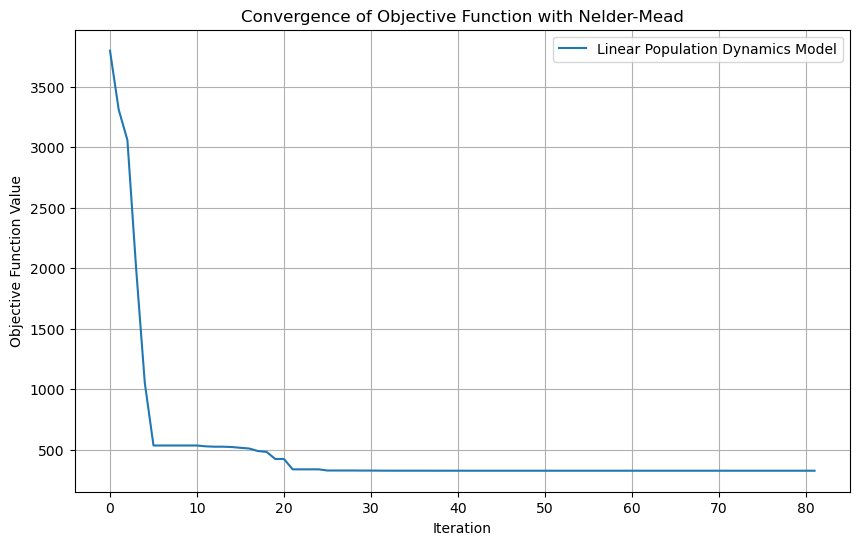

In [10]:
# Plot the convergence over iterations
plt.figure(figsize=(10, 6))
plt.plot(result_hist, label='Linear Population Dynamics Model')
plt.title('Convergence of Objective Function with Nelder-Mead')
#plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Evaluate the performance of the Nelder-Mead algorithm

# Calculate the predicted population values
P_pred_gaussian = X_gaussian @ result_params
# Metrics
mae_gaussian = mae(P_gaussian, P_pred_gaussian)
mse_gaussian = mse(P_gaussian, P_pred_gaussian)
medad_gaussian = medad(P_gaussian, P_pred_gaussian)
bp_gaussian = breakdown_point(P_gaussian, P_pred_gaussian)

print('Linear Population Dynamics Model:')
print(f'MAE: {mae_gaussian:.2f}, MSE: {mse_gaussian:.2f}, MedAD: {medad_gaussian:.2f}, BP: {bp_gaussian:.2f}')


Linear Population Dynamics Model:
MAE: 3.27, MSE: 16.78, MedAD: 2.80, BP: 0.81


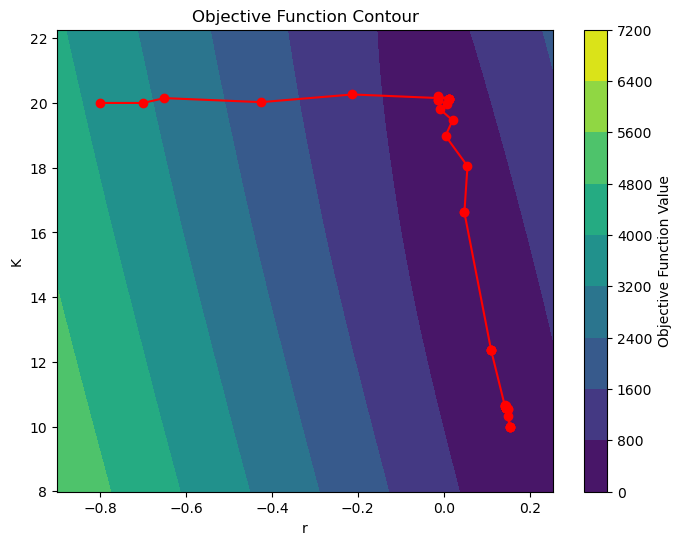

Objective Function Value: 326.9738


In [12]:
#print(result_path)

# Plot the path
K_values = [param[1] for param in result_path]
r_values = [param[0] for param in result_path]

# Plot the 2D contour
plt.figure(figsize=(8, 6))
plt.contourf(R, K, Z, cmap='viridis')
plt.colorbar(label='Objective Function Value')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Objective Function Contour')

# Plot the Nelder-Mead path
plt.plot(r_values, K_values, '-o', color='red')

# Set the x and y axis limits to zoom in
plt.xlim(min(r_values) - 0.1, max(r_values) + 0.1)
plt.ylim(min(K_values) - 2, max(K_values) + 2)

#plt.grid(True)
plt.show()

# Obj function value
print(f'Objective Function Value: {result_hist[-1]:.4f}')

#### Logistic Growth Model

In [180]:
# Test on Logistic Growth Model

# Initial guess for r and K
initial_guess = [-0.2, 650]

result_params_log, result_hist_log, result_path_log, fun_eval_log = nelder_mead(
    f=lambda params: lad_objective_log(params, P_log, time_steps),
    x_start=initial_guess,
    step=0.1,
    no_improve_thr=1e-5,
    no_improv_break=5,
    max_iter=1000
)

# Extract the estimated parameters
estimated_K_log, estimated_r_log = result_params_log

print(f'Estimated r: {estimated_r_log:.4f}')
print(f'Estimated K: {estimated_K_log:.4f}')
print(f'Function evaluations: {fun_eval_log}')
print(f'Number of iterations: {len(result_hist_log)}')


Estimated r: 0.1017
Estimated K: 493.0945
Function evaluations: 227
Number of iterations: 80


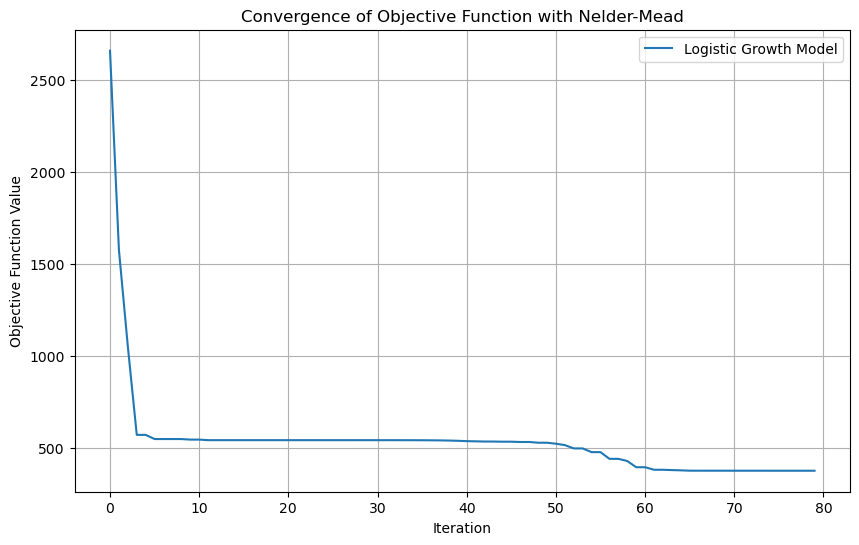

In [181]:
# Plot the convergence of the objective function

plt.figure(figsize=(10, 6))
plt.plot(result_hist_log, label='Logistic Growth Model')
plt.title('Convergence of Objective Function with Nelder-Mead')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()


In [182]:
# Evaluate the performance of the Nelder-Mead algorithm on the logistic growth model

# Calculate the predicted population values
P_pred_log = np.zeros(time_steps)
P_pred_log[0] = 10

for t in range(1, time_steps):
    P_pred_log[t] = P_pred_log[t-1] + estimated_r_log * P_pred_log[t-1] * (1 - P_pred_log[t-1] / estimated_K_log)

# Metrics
mae_log = mae(P_log, P_pred_log)
mse_log = mse(P_log, P_pred_log)
medad_log = medad(P_log, P_pred_log)
bp_log = breakdown_point(P_log, P_pred_log)

print('Logistic Growth Model:')
print(f'MAE: {mae_log:.2f}, MSE: {mse_log:.2f}, MedAD: {medad_log:.2f}, BP: {bp_log:.2f}')

Logistic Growth Model:
MAE: 8.39, MSE: 139.02, MedAD: 4.29, BP: 0.63


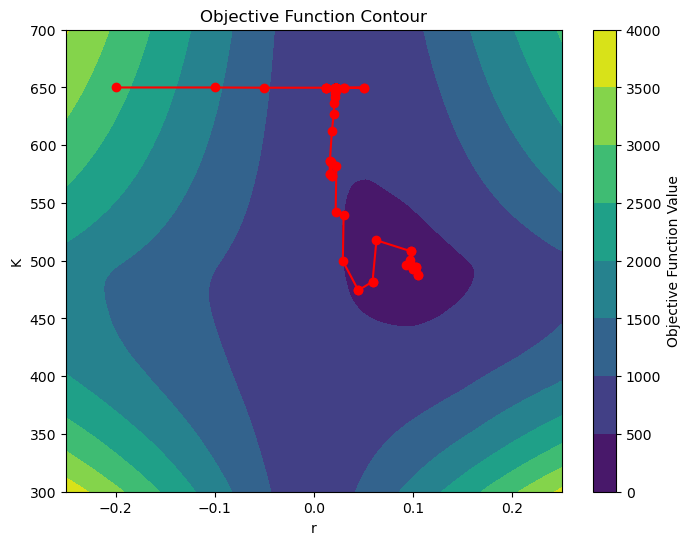

Objective Function Value: 377.7082


In [183]:
# Plot the path on the logistic objective function contour
r_values_log = [param[1] for param in result_path_log]
K_values_log = [param[0] for param in result_path_log]

#print(result_path_log)

# Plot the 2D contour
plt.figure(figsize=(8, 6))
plt.contourf(R, K, Z, cmap='viridis')
plt.colorbar(label='Objective Function Value')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Objective Function Contour')

# Plot the Nelder-Mead path
plt.plot(K_values_log, r_values_log, '-o', color='red')

# Set the x and y axis limits to zoom in
#plt.xlim(min(K_values_log) - 0.01, max(K_values_log) + 0.01)
#plt.ylim(min(r_values_log) - 0.02, max(r_values_log) + 0.02)

plt.show()

# Obj function value
print(f'Objective Function Value: {result_hist_log[-1]:.4f}')

### Sub-gradient line search

In [13]:
def subgradient_line_search(objective_func, X, y, max_iterations=10000, initial_step_size=0.5, step_reduction=0.9,tol=1e-8, initial_guess=None, *args):

    n = X.shape[1] if X is not None else len(initial_guess)

    if initial_guess is not None:
        x = np.array(initial_guess)
    else:
        x = np.zeros(n)  # Initialize coefficients to zero as fallback

    objective_history = []  # To store the history of objective function values
    estimates = []  # To store the estimates at each iteration
    step_size = initial_step_size
    func_evals = 0  #  Function evaluation counter

    for iteration in range(max_iterations):
        if objective_func == lad_objective:
            residuals = X @ x - y
            objective = np.sum(np.abs(residuals))
            # subgradients
            descent_direction = np.sign(residuals) @ X
        elif objective_func == lad_objective_log:
            residuals = np.zeros_like(y)
            r, K = x
            sum_r = 0
            sum_K = 0
            for t in range(1, len(y)):
                P_pred = y[t-1] + r * y[t-1] * (1 - y[t-1] / K)
                residuals[t] = P_pred - y[t]
                # subgradients
                sum_r += np.sign(residuals[t]) * y[t-1] * (1 - y[t-1] / K)
                sum_K += np.sign(residuals[t]) * (-r * y[t-1]**2 / K**2)

            objective = objective_func(x, y, *args)
            descent_direction = np.array([sum_r, sum_K])
        else:
            raise ValueError("Unsupported objective function")

        func_evals += 1  # Increment function evaluation counter for the residual calculation
        objective_history.append(objective)
        estimates.append(x.copy())

        # Save current x to compare after potential update
        current_x = x.copy()

        # Backtracking line search for optimal step size
        while step_size > 1e-8:

            x_new = x - step_size * descent_direction
            if objective_func == lad_objective:
                new_residuals = X @ x_new - y
                new_objective = np.sum(np.abs(new_residuals))
            elif objective_func == lad_objective_log:
                new_objective = objective_func(x_new, y, *args)
            else:
                raise ValueError("Unsupported objective function")
            func_evals += 1

            # If the new objective function value is smaller, break and accept new coefficients
            if new_objective < objective:
                print(descent_direction)
                print('step: ', step_size)
                x = x_new
                objective = new_objective
                break
            else:
                step_size *= step_reduction  # Reduce step size

        # Calculate the change in coefficients
        delta_x = np.linalg.norm(x - current_x)

        # Check convergence
        if delta_x < tol:
            break

        # Reset step size for next iteration
        step_size = initial_step_size

    return x, objective_history, estimates, func_evals


#### Linear Population Dynamics Model

In [15]:
# Test

initial_guess=[20, -0.8]
coeffs_sgls_lin_pop, history_sgls_lin_pop, estimates_lin_pop, fun_eval = subgradient_line_search(lad_objective, X_gaussian, P_gaussian, initial_step_size=0.5, step_reduction=0.2, initial_guess=initial_guess)


print('\nLinear Population Dynamics Model:')
print(coeffs_sgls_lin_pop)
print(f'Function evaluations: {fun_eval}')

[  -84. -4878.]
step:  0.00016000000000000007
[  26. -436.]
step:  3.200000000000001e-05
[32.  2.]
step:  0.004000000000000001
[  28. -258.]
step:  3.200000000000001e-05
[32.  2.]
step:  0.004000000000000001
[  28. -258.]
step:  3.200000000000001e-05
[32.  2.]
step:  0.004000000000000001
[  28. -258.]
step:  3.200000000000001e-05
[  30. -154.]
step:  3.200000000000001e-05
[32.  2.]
step:  0.004000000000000001
[  28. -258.]
step:  3.200000000000001e-05
[32.  2.]
step:  0.004000000000000001
[  28. -258.]
step:  3.200000000000001e-05
[32.  2.]
step:  0.004000000000000001
[  26. -372.]
step:  3.200000000000001e-05
[32.  2.]
step:  0.004000000000000001
[  28. -258.]
step:  3.200000000000001e-05
[32.  2.]
step:  0.004000000000000001
[  26. -372.]
step:  3.200000000000001e-05
[32.  2.]
step:  0.004000000000000001
[  24. -276.]
step:  3.200000000000001e-05
[30. -6.]
step:  0.0008000000000000003
[30. -6.]
step:  0.0008000000000000003
[30. -6.]
step:  0.0008000000000000003
[ 36. 364.]
step:  3.2

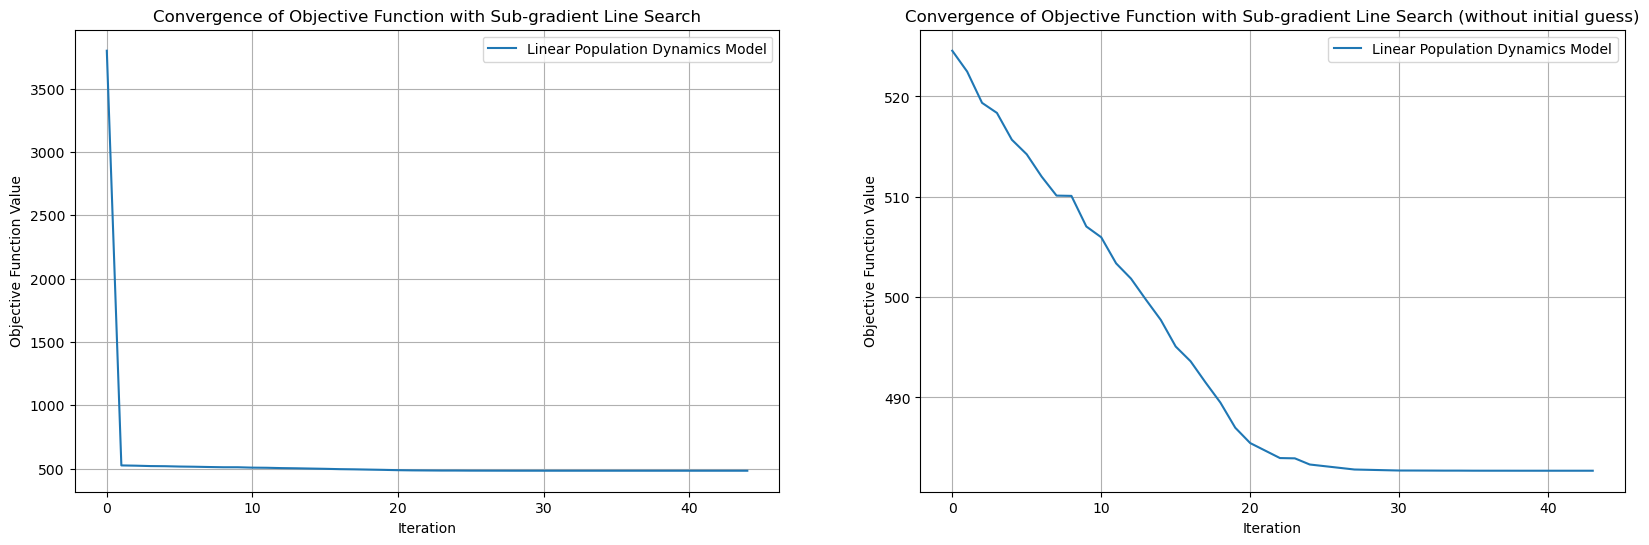

In [16]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot on the first subplot
ax1.plot(history_sgls_lin_pop, label='Linear Population Dynamics Model')
ax1.set_title('Convergence of Objective Function with Sub-gradient Line Search')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective Function Value')
ax1.legend()
ax1.grid(True)

# Plot on the second subplot, starting from the first element
ax2.plot(history_sgls_lin_pop[1:], label='Linear Population Dynamics Model')
ax2.set_title('Convergence of Objective Function with Sub-gradient Line Search (without initial guess)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective Function Value')
ax2.legend()
ax2.grid(True)

# Show the plots
plt.show()

In [17]:
# Evaluate

# Linear Population Dynamics Model
P_pred_gaussian = X_gaussian @ coeffs_sgls_lin_pop
# Metrics
mae_lin_pop = mae(P_gaussian, P_pred_gaussian)
mse_lin_pop = mse(P_gaussian, P_pred_gaussian)
medad_lin_pop = medad(P_gaussian, P_pred_gaussian)
bp_lin_pop = breakdown_point(P_gaussian, P_pred_gaussian)

print('\nLinear Population Dynamics Model:')
print(f'MAE: {mae_lin_pop:.2f}, MSE: {mse_lin_pop:.2f}, MedAD: {medad_lin_pop:.2f}, BP: {bp_lin_pop:.2f}')


Linear Population Dynamics Model:
MAE: 4.83, MSE: 33.86, MedAD: 4.48, BP: 1.00


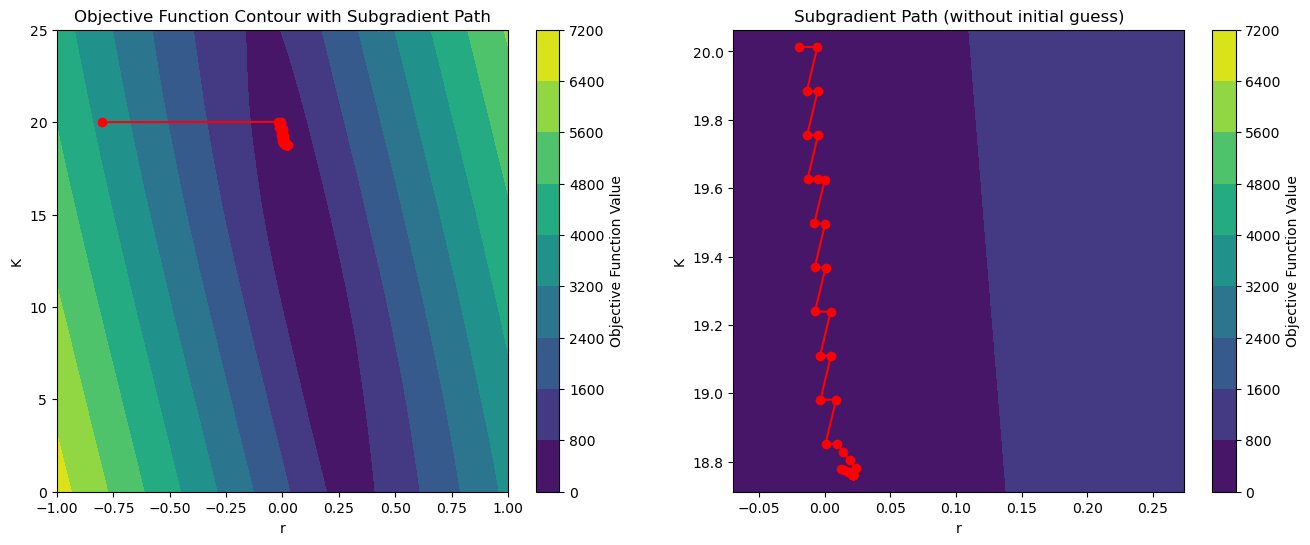

Objective Function Value: 482.6902


In [97]:
# Plot the path

#print(estimates_lin_pop)

r_values = [param[1] for param in estimates_lin_pop]
K_values = [param[0] for param in estimates_lin_pop]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Contour plot on the first subplot
contour1 = ax1.contourf(R, K, Z, cmap='viridis')
fig.colorbar(contour1, ax=ax1, label='Objective Function Value')
ax1.plot(r_values, K_values, '-o', color='red')
#ax1.set_xlim(min(r_values) - 0.2, max(r_values) + 0.5)
#ax1.set_ylim(min(K_values) - 0.5, max(K_values) + 0.5)
ax1.set_xlabel('r')
ax1.set_ylabel('K')
ax1.set_title('Objective Function Contour with Subgradient Path')

# Contour plot on the second subplot, omitting the first data point
contour2 = ax2.contourf(R, K, Z, cmap='viridis')
fig.colorbar(contour2, ax=ax2, label='Objective Function Value')
ax2.plot(r_values[1:], K_values[1:], '-o', color='red')
ax2.set_xlim(min(r_values[1:]) - 0.05, max(r_values[1:]) + 0.25)
ax2.set_ylim(min(K_values[1:]) - 0.05, max(K_values[1:]) + 0.05)
ax2.set_xlabel('r')
ax2.set_ylabel('K')
ax2.set_title('Subgradient Path (without initial guess)')

plt.show()

# Obj function value
print(f'Objective Function Value: {history_sgls_lin_pop[-1]:.4f}')

#### Logistic Growth Model

In [21]:
# Test on Logistic Growth Model

time_steps = 100
initial_guess = [-0.2, 650]

coeffs_sgls_log, history_sgls_log, estimates_log, fun_eval_log = subgradient_line_search(
    lad_objective_log, None, P_log, 100000, 0.5, 0.5, 1e-12, initial_guess, time_steps)

print('\nLogistic Growth Model:')
print(coeffs_sgls_log)
print(f'Function evaluations: {fun_eval_log}')


[-1.08716693e+04 -5.69560507e+00]
step:  3.0517578125e-05
[ 9.06862924e+03 -3.59055336e+00]
step:  1.52587890625e-05
[-7.12152471e+03 -1.15960079e-01]
step:  7.62939453125e-06
[ 1.92694601e+03 -7.94360110e-01]
step:  1.52587890625e-05
[-5.72069436e+02 -1.89499299e-01]
step:  7.62939453125e-06
[171.15733371  -0.30990258]
step:  1.52587890625e-05
[-68.46646213  -0.25126723]
step:  3.0517578125e-05
[171.15750298  -0.30277165]
step:  3.814697265625e-06
[-68.46635174  -0.26923952]
step:  7.62939453125e-06
[171.1575468  -0.3009889]
step:  1.9073486328125e-06
[-68.46631886  -0.27169042]
step:  3.814697265625e-06
[171.1575688   -0.30009753]
step:  9.5367431640625e-07
[-68.46630231  -0.27291587]
step:  9.5367431640625e-07
[-68.46629906  -0.27373277]
step:  4.76837158203125e-07
[171.15757804  -0.29920604]
step:  1.1920928955078125e-07
[-68.46629698  -0.27388595]
step:  2.384185791015625e-07
[171.15757942  -0.29915033]
step:  5.960464477539063e-08
[-68.46629594  -0.27396254]
step:  1.192092895507

34


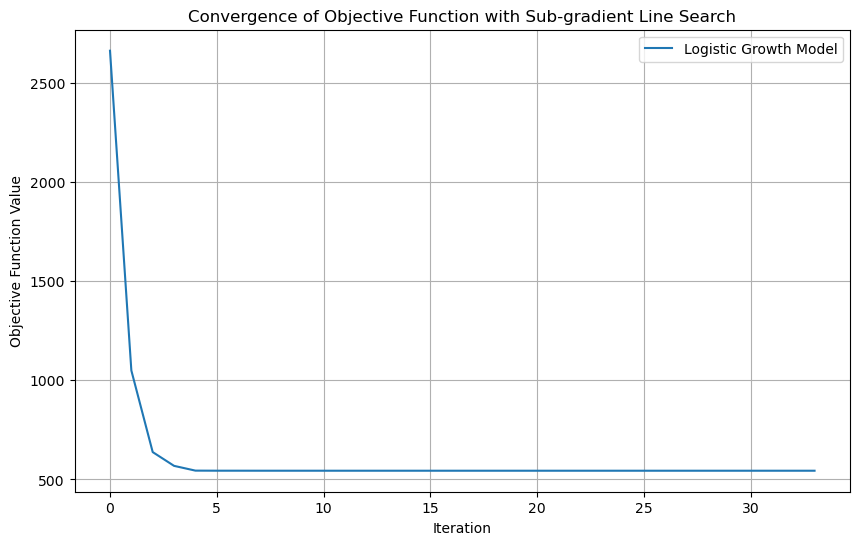

In [22]:
# Plot the convergence of the objective function
print(len(history_sgls_log))

plt.figure(figsize=(10, 6))
plt.plot(history_sgls_log, label='Logistic Growth Model')
plt.title('Convergence of Objective Function with Sub-gradient Line Search')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Evaluate the performance of the Subgradient method on the logistic growth model

#print(coeffs_sgls_log)

# Calculate the predicted population values
P_pred_log = np.zeros(time_steps)
P_pred_log[0] = 10

for t in range(1, time_steps):
    P_pred_log[t] = P_pred_log[t-1] + coeffs_sgls_log[0] * P_pred_log[t-1] * (1 - P_pred_log[t-1] / coeffs_sgls_log[1])
# Metrics
mae_log = mae(P_log, P_pred_log)
mse_log = mse(P_log, P_pred_log)
medad_log = medad(P_log, P_pred_log)
bp_log = breakdown_point(P_log, P_pred_log)

print('\nLogistic Growth Model:')
print(f'MAE: {mae_log:.2f}, MSE: {mse_log:.2f}, MedAD: {medad_log:.2f}, BP: {bp_log:.2f}')


Logistic Growth Model:
MAE: 265.38, MSE: 98110.47, MedAD: 320.75, BP: 1.00


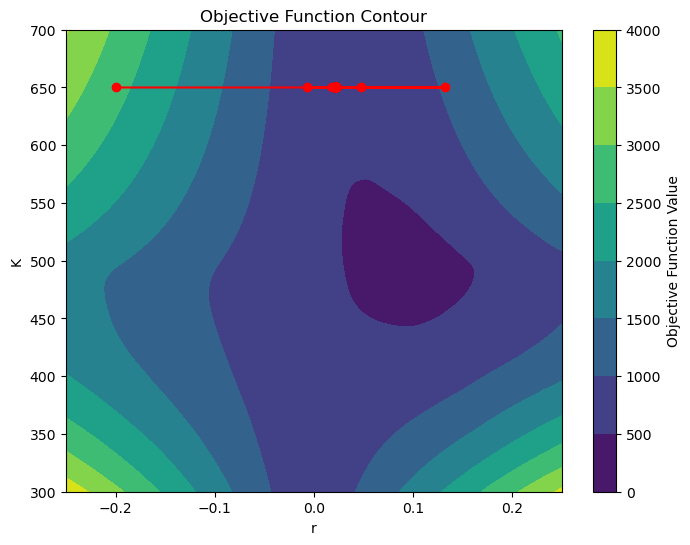

Objective Function Value: 543.8874


In [26]:
# Plot the path on the logistic objective function contour

r_values_log = [param[0] for param in estimates_log]
K_values_log = [param[1] for param in estimates_log]

# Plot the 2D contour
plt.figure(figsize=(8, 6))
plt.contourf(R, K, Z, cmap='viridis')
plt.colorbar(label='Objective Function Value')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Objective Function Contour')

# Plot the Subgradient path
plt.plot(r_values_log, K_values_log, '-o', color='red')

# Set the x and y axis limits to zoom in
#plt.xlim(min(r_values_log) - 0.01, max(r_values_log) + 0.01)
#plt.ylim(min(K_values_log) - 0.01, max(K_values_log) + 0.01)

plt.show()

# Obj function value
print(f'Objective Function Value: {history_sgls_log[-1]:.4f}')



### Smoothing with Sub-sequent Gradient Descent

#### Linear Population Dynamics Model

In [1169]:
# Smoothed absolute value function
def smooth_abs(x, alpha):
    return (2 / alpha) * np.log1p(np.exp(alpha * x)) + (2 / alpha) * np.log1p(np.exp(-alpha * x))

# Smoothed LAD objective function
def smoothed_lad_objective(params, P, X, alpha):
    r, K = params
    P_pred = X @ np.array([K, r])
    residuals = P - P_pred
    return np.sum(smooth_abs(residuals, alpha))

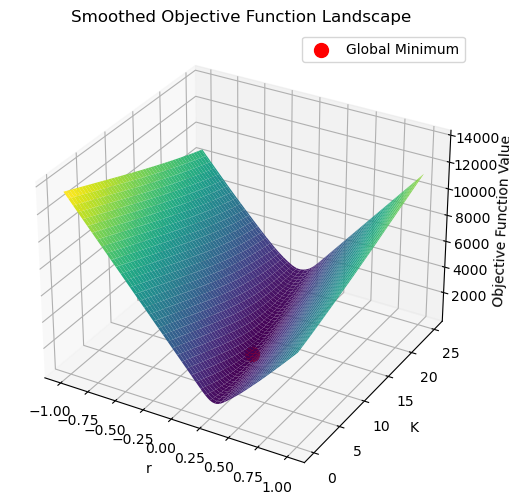

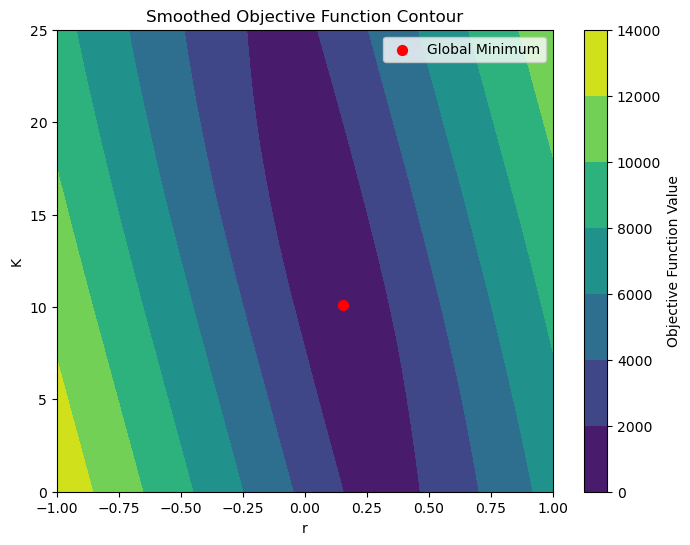

Smoothed Global minimum at r = 0.1515, K = 10.1010, Objective = 659.8909


In [1170]:
# Smoothing parameter
alpha = 5.0

# Function to create a grid and evaluate the smoothed objective function
def create_smoothed_objective_landscape(P, X, r_range, K_range, alpha, grid_size=100):
    r_values = np.linspace(r_range[0], r_range[1], grid_size)
    K_values = np.linspace(K_range[0], K_range[1], grid_size)
    R, K = np.meshgrid(r_values, K_values)
    Z = np.zeros_like(R)

    for i in range(grid_size):
        for j in range(grid_size):
            Z[i, j] = smoothed_lad_objective([R[i, j], K[i, j]], P, X, alpha)

    return R, K, Z

# Create smoothed objective landscape
r_range = [-1, 1]
K_range = [0, 25]
R_smoothed, K_smoothed, Z_smoothed = create_smoothed_objective_landscape(P_gaussian, X_gaussian, r_range, K_range, alpha)

# Find the global minimum
min_idx_smoothed = np.unravel_index(np.argmin(Z_smoothed), Z_smoothed.shape)
min_r_smoothed = R_smoothed[min_idx_smoothed]
min_K_smoothed = K_smoothed[min_idx_smoothed]
min_value_smoothed = Z_smoothed[min_idx_smoothed]

# Plot the 3D landscape with the minimum highlighted
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(R_smoothed, K_smoothed, Z_smoothed, cmap='viridis')
min_dot = ax.scatter(min_r_smoothed, min_K_smoothed, min_value_smoothed, color='r', s=100, label='Global Minimum')
ax.set_title('Smoothed Objective Function Landscape')
ax.set_xlabel('r')
ax.set_ylabel('K')
ax.set_zlabel('Objective Function Value')
ax.legend()
plt.show()

# Plot the 2D contour with the minimum highlighted
plt.figure(figsize=(8, 6))
contour = plt.contourf(R_smoothed, K_smoothed, Z_smoothed, cmap='viridis')
plt.colorbar(label='Objective Function Value')
plt.scatter(min_r_smoothed, min_K_smoothed, color='red', s=50, label='Global Minimum')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Smoothed Objective Function Contour')
plt.legend()
plt.show()

# Print the global minima values
print(f'Smoothed Global minimum at r = {min_r_smoothed:.4f}, K = {min_K_smoothed:.4f}, Objective = {min_value_smoothed:.4f}')

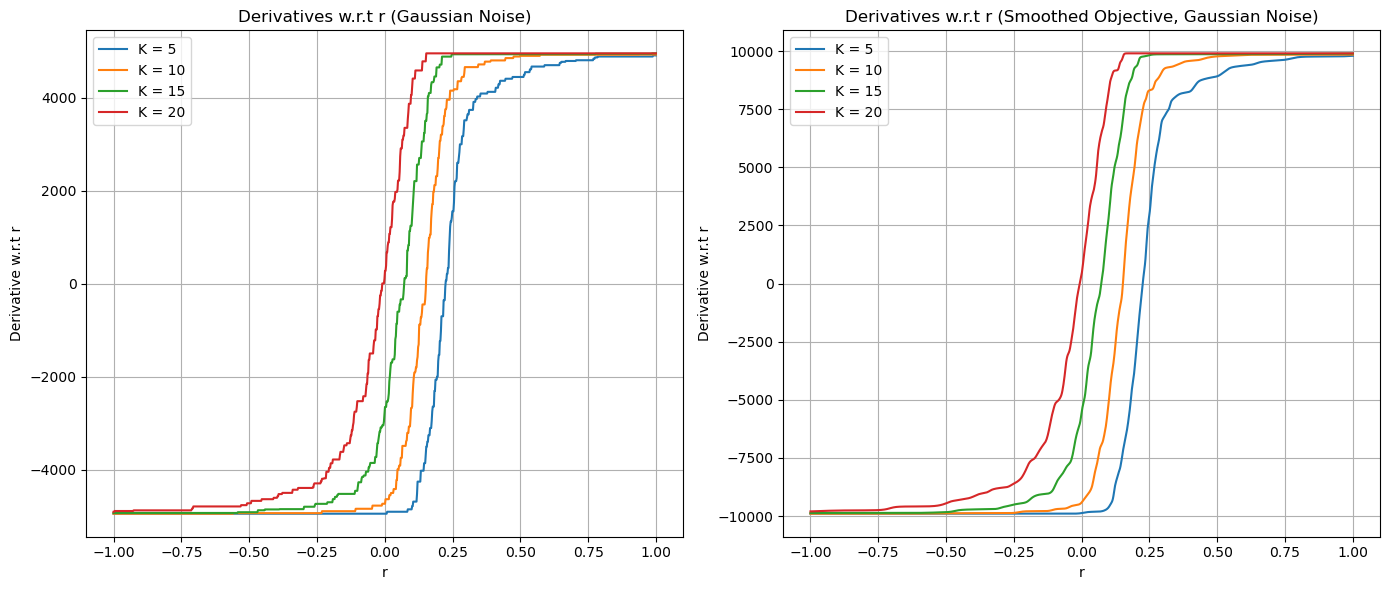

In [103]:
# Partial derivatives of the smoothed objective

# Define the gradient function for the original LAD objective
grad_lad_r = grad(lambda params, P, X: lad_objective(params, P, X), 0)

# Function to compute gradients along r and K for LAD objective
def compute_gradients(P, X, r_values, K_values):
    gradients_r = np.zeros((len(r_values), len(K_values)))
    gradients_K = np.zeros((len(r_values), len(K_values)))
    for i, r in enumerate(r_values):
        for j, K in enumerate(K_values):
            grad_r = grad_lad_r([float(r), float(K)], P, X)[0]
            grad_K = grad_lad_r([float(r), float(K)], P, X)[1]
            gradients_r[i, j] = grad_r
            gradients_K[i, j] = grad_K
    return gradients_r, gradients_K

# Define the gradient function for the smoothed LAD objective
grad_smoothed_lad = grad(lambda params, P, X, alpha: smoothed_lad_objective(params, P, X, alpha), 0)

# Function to compute gradients along r and K for the smoothed LAD objective
def compute_smoothed_gradients(P, X, r_values, K_values, alpha):
    gradients_r = np.zeros((len(r_values), len(K_values)))
    gradients_K = np.zeros((len(r_values), len(K_values)))
    for i, r in enumerate(r_values):
        for j, K in enumerate(K_values):
            grad_r = grad_smoothed_lad([float(r), float(K)], P, X, alpha)[0]
            grad_K = grad_smoothed_lad([float(r), float(K)], P, X, alpha)[1]
            gradients_r[i, j] = grad_r
            gradients_K[i, j] = grad_K
    return gradients_r, gradients_K

# Define ranges for r and K
r_values = np.linspace(-1, 1, 1000)
K_values = np.linspace(0, 25, 1000)
K_lines = [5, 10, 15, 20]

# Compute gradients for the original LAD objective
gradients_r_gaussian, _ = compute_gradients(P_gaussian, X_gaussian, r_values, K_values)

# Compute gradients for the smoothed LAD objective
alpha = 5
gradients_r_smoothed, _ = compute_smoothed_gradients(P_gaussian, X_gaussian, r_values, K_values, alpha)

# Find the closest indices in K_values for the specific lines
K_indices = [np.abs(K_values - K).argmin() for K in K_lines]

# Plotting derivatives with respect to r for both datasets
plt.figure(figsize=(14, 6))

# Plot 1: Derivatives for original objective (Gaussian Noise)
plt.subplot(1, 2, 1)
for K_index, K in zip(K_indices, K_lines):
    plt.plot(r_values, gradients_r_gaussian[:, K_index], label=f'K = {K}')
plt.title('Derivatives w.r.t r (Gaussian Noise)')
plt.xlabel('r')
plt.ylabel('Derivative w.r.t r')
plt.legend()
plt.grid(True)

# Plot 2: Derivatives for smoothed objective (Gaussian Noise)
plt.subplot(1, 2, 2)
for K_index, K in zip(K_indices, K_lines):
    plt.plot(r_values, gradients_r_smoothed[:, K_index], label=f'K = {K}')
plt.title('Derivatives w.r.t r (Smoothed Objective, Gaussian Noise)')
plt.xlabel('r')
plt.ylabel('Derivative w.r.t r')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [1171]:
# Gradient descent

def compute_gradients(params, P, X, alpha):
    grad_vals = grad_smoothed_lad(params, P, X, alpha)
    return grad_vals

def gradient_descent_smoothed(P, X, alpha, lr=0.00001, iterations=100000, tol=1e-7, initial_guess=None):
    history = []
    path = []

    if initial_guess is None:
        params = np.array([0.0, 0.0])  # Default initial guess for [r, K]
    else:
        params = np.array(initial_guess)

    func_evals = 0
    grad_evals = 0

    # Evaluate the initial objective function
    objective_value = smoothed_lad_objective(params, P, X, alpha)
    func_evals += 1
    history.append(objective_value)
    path.append(params.copy())

    for i in range(iterations):
        grad = compute_gradients(params, P, X, alpha)
        grad_evals += 1
        params -= lr * grad
        objective_value = smoothed_lad_objective(params, P, X, alpha)
        func_evals += 1
        history.append(objective_value)
        path.append(params.copy())

        # Check for convergence using the gradient norm
        if np.linalg.norm(grad) < tol:
            print(f"Convergence reached based on gradient norm at iteration {i}")
            break

        # Check for convergence using the relative change in objective function value
        if i > 0 and abs(history[-1] - history[-2]) < tol:
            print(f"Convergence reached based on objective change at iteration {i}")
            break

    return params, history, path, func_evals, grad_evals


In [1172]:
# Test

alpha = 5.0
initial_guess = [-0.8, 20]

result_params_smoothed, result_hist_smoothed, result_path_smoothed, fun_eval_smoothed, grad_eval_smoothed = gradient_descent_smoothed(P_gaussian, X_gaussian, alpha, initial_guess=initial_guess)

# Extract the estimated parameters
estimated_r_smoothed, estimated_K_smoothed = result_params_smoothed

print(f'Estimated r: {estimated_r_smoothed:.4f}')
print(f'Estimated K: {estimated_K_smoothed:.4f}')
print(f'Function evaluations: {fun_eval_smoothed}')
print(f'Gradient evaluations: {grad_eval_smoothed}')


Convergence reached based on objective change at iteration 58799
Estimated r: 0.1428
Estimated K: 10.6443
Function evaluations: 58801
Gradient evaluations: 58800


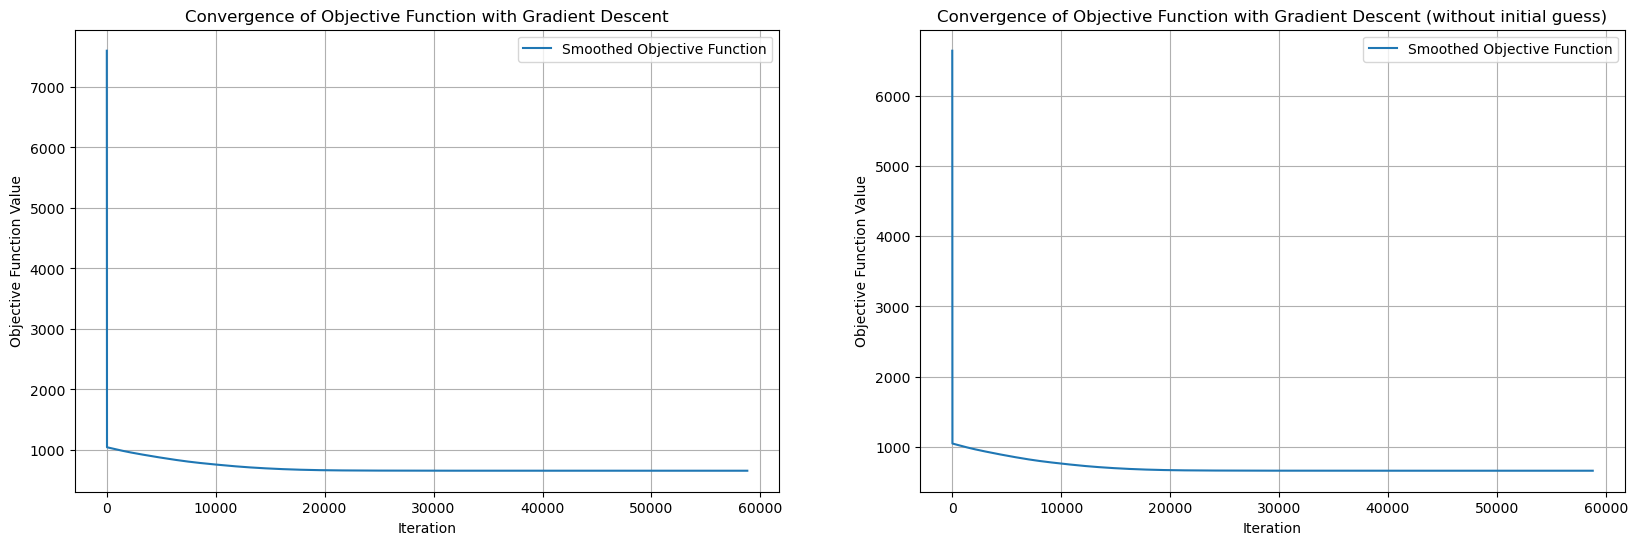

In [89]:
# Plot the convergence of the objective function
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot on the first subplot
ax1.plot(result_hist_smoothed, label='Smoothed Objective Function')
ax1.set_title('Convergence of Objective Function with Gradient Descent')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective Function Value')
ax1.legend()
ax1.grid(True)

# Plot on the second subplot, starting from the first element
ax2.plot(result_hist_smoothed[1:], label='Smoothed Objective Function')
ax2.set_title('Convergence of Objective Function with Gradient Descent (without initial guess)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective Function Value')
ax2.legend()
ax2.grid(True)

# Show the plots
plt.show()

In [90]:
# Evaluate

# Calculate the predicted population values
P_pred_gaussian = X_gaussian @ result_params_smoothed[::-1]
# Metrics
mae_gaussian = mae(P_gaussian, P_pred_gaussian)
mse_gaussian = mse(P_gaussian, P_pred_gaussian)
medad_gaussian = medad(P_gaussian, P_pred_gaussian)
bp_gaussian = breakdown_point(P_gaussian, P_pred_gaussian)

print('Linear Population Dynamics Model:')
print(f'MAE: {mae_gaussian:.2f}, MSE: {mse_gaussian:.2f}, MedAD: {medad_gaussian:.2f}, BP: {bp_gaussian:.2f}')

Linear Population Dynamics Model:
MAE: 3.27, MSE: 16.77, MedAD: 2.76, BP: 0.80


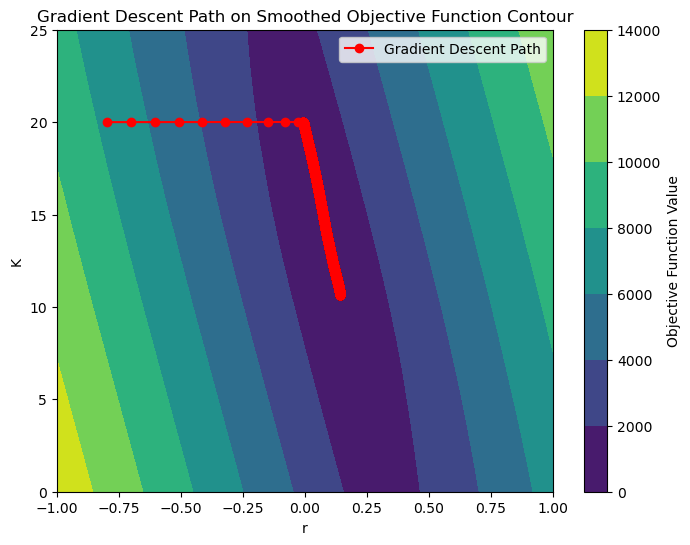

Final objective value: 657.9460


In [91]:
# Plotting the path of gradient descent on the smoothed objective landscape
K_values = [param[1] for param in result_path_smoothed]
r_values = [param[0] for param in result_path_smoothed]

# Plot the 2D contour with the gradient descent path highlighted
plt.figure(figsize=(8, 6))
contour = plt.contourf(R_smoothed, K_smoothed, Z_smoothed, cmap='viridis')
plt.colorbar(label='Objective Function Value')
plt.plot(r_values, K_values, '-o', color='red', label='Gradient Descent Path')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Gradient Descent Path on Smoothed Objective Function Contour')
plt.legend()
#plt.grid(True)
plt.show()

# Print the final objective value
print(f'Final objective value: {result_hist_smoothed[-1]:.4f}')

#### Logistic Growth Model

In [82]:
# Smoothed absolute value function
def smooth_abs(x, alpha):
    return (2 / alpha) * np.log1p(np.exp(alpha * x)) + (2 / alpha) * np.log1p(np.exp(-alpha * x))

# Smoothed LAD objective function for logistic growth model
def smoothed_lad_objective_log(params, P, time_steps, alpha):
    r, K = params
    sum_absolute_deviation = 0
    for t in range(1, time_steps):
        P_pred = P[t-1] + r * P[t-1] * (1 - P[t-1] / K)
        residual = P[t] - P_pred
        sum_absolute_deviation += smooth_abs(residual, alpha)
    return sum_absolute_deviation


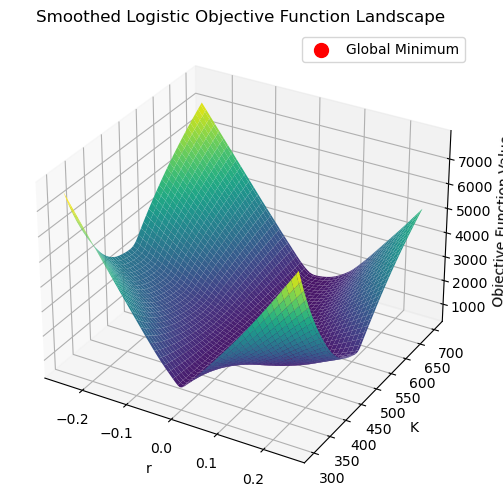

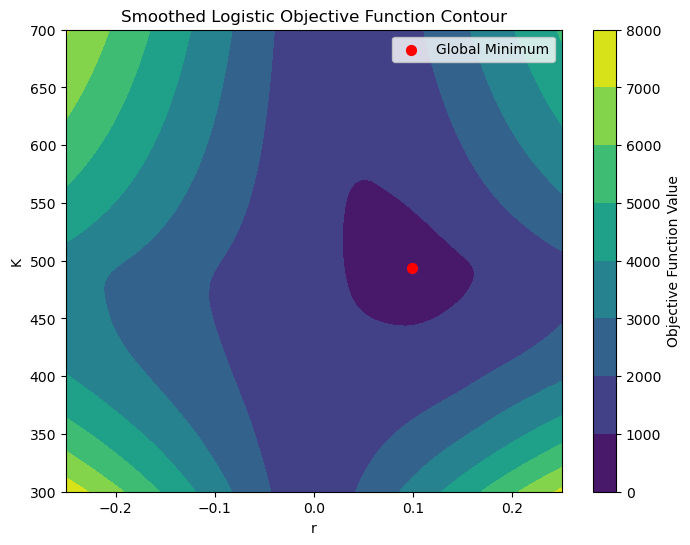

Smoothed Global minimum at r = 0.0985, K = 493.9394, Objective = 763.7800


In [111]:
# Function to create a grid and evaluate the smoothed logistic objective function
def create_smoothed_logistic_objective_landscape(P, time_steps, r_range, K_range, alpha, grid_size=100):
    r_values = np.linspace(r_range[0], r_range[1], grid_size)
    K_values = np.linspace(K_range[0], K_range[1], grid_size)
    R, K = np.meshgrid(r_values, K_values)
    Z = np.zeros_like(R)

    for i in range(grid_size):
        for j in range(grid_size):
            Z[i, j] = smoothed_lad_objective_log([R[i, j], K[i, j]], P, time_steps, alpha)

    return R, K, Z

# Smoothing parameter
alpha = 5.0

# Ranges for r and K
r_range = [-0.25, 0.25]
K_range = [300, 700]
R_smoothed, K_smoothed, Z_smoothed = create_smoothed_logistic_objective_landscape(P_log, time_steps, r_range, K_range, alpha)

# Find the global minimum
min_idx_smoothed = np.unravel_index(np.argmin(Z_smoothed), Z_smoothed.shape)
min_r_smoothed = R_smoothed[min_idx_smoothed]
min_K_smoothed = K_smoothed[min_idx_smoothed]
min_value_smoothed = Z_smoothed[min_idx_smoothed]

# Plot the 3D landscape with the minimum highlighted
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(R_smoothed, K_smoothed, Z_smoothed, cmap='viridis')
min_dot = ax.scatter(min_r_smoothed, min_K_smoothed, min_value_smoothed, color='r', s=100, label='Global Minimum')
ax.set_title('Smoothed Logistic Objective Function Landscape')
ax.set_xlabel('r')
ax.set_ylabel('K')
ax.set_zlabel('Objective Function Value')
ax.legend()
plt.show()

# Plot the 2D contour with the minimum highlighted
plt.figure(figsize=(8, 6))
contour = plt.contourf(R_smoothed, K_smoothed, Z_smoothed, cmap='viridis')
plt.colorbar(contour, label='Objective Function Value')
plt.scatter(min_r_smoothed, min_K_smoothed, color='red', s=50, label='Global Minimum')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Smoothed Logistic Objective Function Contour')
plt.legend()
plt.show()

# Print the global minima values
print(f'Smoothed Global minimum at r = {min_r_smoothed:.4f}, K = {min_K_smoothed:.4f}, Objective = {min_value_smoothed:.4f}')


#### Highlight Plateau Regions

In [83]:
grad_smoothed_lad_log = grad(smoothed_lad_objective_log)

# Function to evaluate the smoothed objective and gradient at a given point
def evaluate_smoothed_point(i, j, R, K, P, time_steps, alpha):
    params = [R[i, j], K[i, j]]
    Z_value = smoothed_lad_objective_log(params, P, time_steps, alpha)
    grads = grad_smoothed_lad_log(params, P, time_steps, alpha)
    grad_magnitude_value = np.linalg.norm(grads)
    return i, j, Z_value, grad_magnitude_value

# Function to create a grid and evaluate the smoothed logistic objective function using multithreading
def create_smoothed_logistic_objective_landscape(P, time_steps, r_range, K_range, alpha, grid_size=1000):
    r_values = np.linspace(r_range[0], r_range[1], grid_size)
    K_values = np.linspace(K_range[0], K_range[1], grid_size)
    R, K = np.meshgrid(r_values, K_values)
    Z = np.zeros_like(R)
    grad_magnitude = np.zeros_like(R)

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(evaluate_smoothed_point, i, j, R, K, P, time_steps, alpha) for i in range(grid_size) for j in range(grid_size)]
        for future in futures:
            i, j, Z_value, grad_magnitude_value = future.result()
            Z[i, j] = Z_value
            grad_magnitude[i, j] = grad_magnitude_value

    return R, K, Z, grad_magnitude

# Identify plateau regions
def identify_plateaus(grad_magnitude, threshold=1.0):
    return grad_magnitude < threshold

# Smoothing parameter
alpha = 5.0

# Ranges for r and K
r_range = [-0.25, 0.25]
K_range = [300, 700]

# Create the smoothed logistic objective landscape
R_smoothed, K_smoothed, Z_smoothed, grad_magnitude_smoothed = create_smoothed_logistic_objective_landscape(P_log, time_steps, r_range, K_range, alpha)

# Find the global minimum
min_idx_smoothed = np.unravel_index(np.argmin(Z_smoothed), Z_smoothed.shape)
min_r_smoothed = R_smoothed[min_idx_smoothed]
min_K_smoothed = K_smoothed[min_idx_smoothed]
min_value_smoothed = Z_smoothed[min_idx_smoothed]

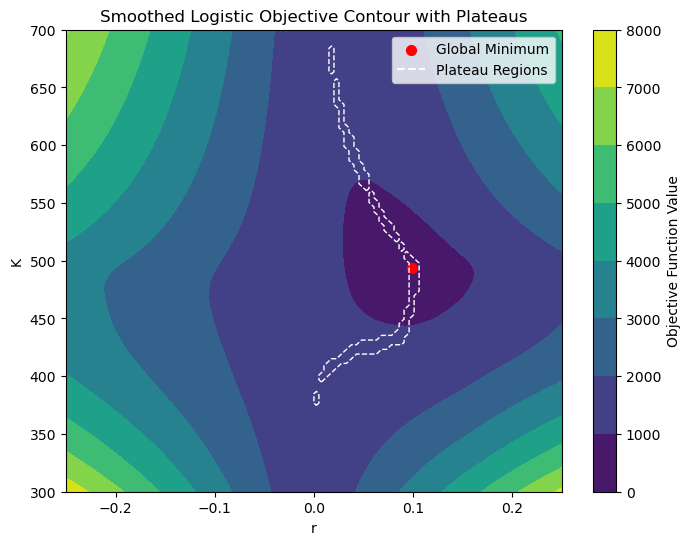

In [85]:

plateau_regions_smoothed = identify_plateaus(grad_magnitude_smoothed, threshold=100.0)

# Plot the 2D contour with the minimum and plateau regions highlighted
plt.figure(figsize=(8, 6))
contour = plt.contourf(R_smoothed, K_smoothed, Z_smoothed, cmap='viridis')
plt.colorbar(contour, label='Objective Function Value')
plt.scatter(min_r_smoothed, min_K_smoothed, color='red', s=50, label='Global Minimum')
plt.contour(R_smoothed, K_smoothed, plateau_regions_smoothed, colors='white', linewidths=1, linestyles='dashed')
plt.plot([], [], 'w--', label='Plateau Regions')  # Dummy plot for legend
plt.xlabel('r')
plt.ylabel('K')
plt.title('Smoothed Logistic Objective Contour with Plateaus')
plt.legend()
plt.show()

#### Partial derivatives of the smoothed logistic objective

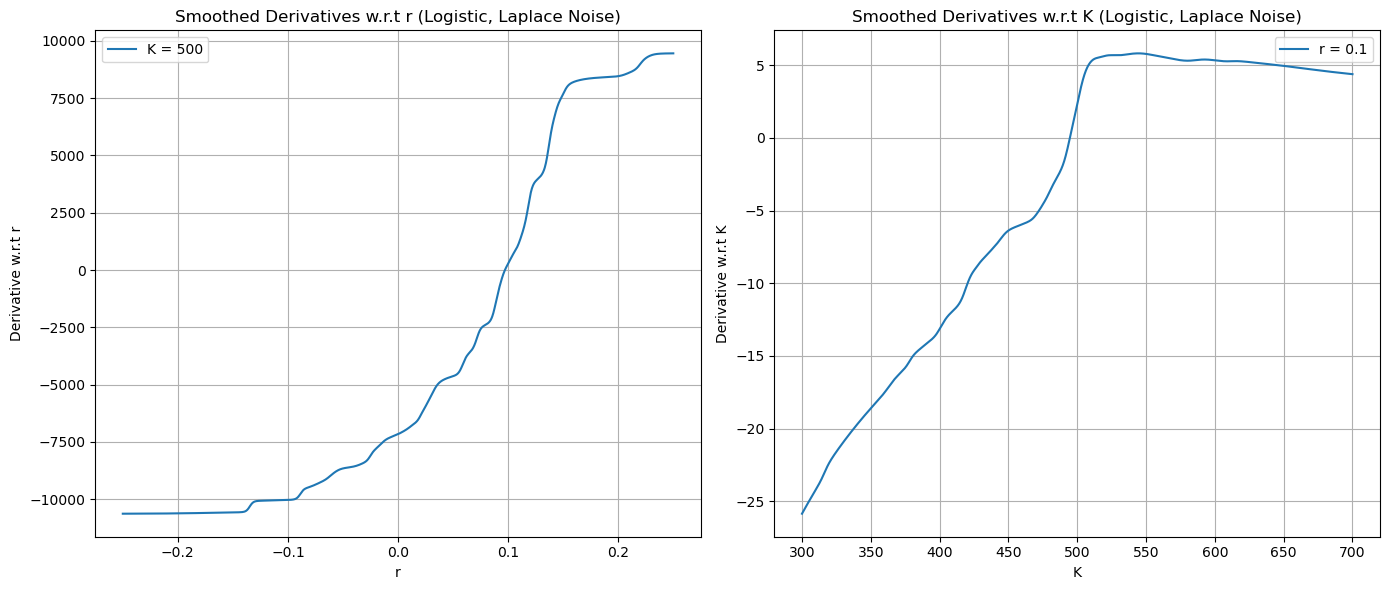

In [889]:
# Function to compute gradients with respect to r for a fixed K
def compute_smoothed_logistic_gradients_r(P, time_steps, r_values, fixed_K, alpha):
    def compute_gradient(r):
        return grad_smoothed_lad_log([float(r), float(fixed_K)], np.array(P, dtype=float), int(time_steps), alpha)[0]

    gradients_r = Parallel(n_jobs=-1)(delayed(compute_gradient)(r) for r in r_values)
    return np.array(gradients_r)

# Define ranges for r
r_values = np.linspace(-0.25, 0.25, 1500)
fixed_K = 500

gradients_r_logistic = compute_smoothed_logistic_gradients_r(P_log, time_steps, r_values, fixed_K, alpha)




# Function to compute gradients with respect to K for a fixed r
def compute_smoothed_logistic_gradients_K(P, time_steps, fixed_r, K_values, alpha):
    def compute_gradient(K):
        return grad_smoothed_lad_log([float(fixed_r), float(K)], np.array(P, dtype=float), int(time_steps), alpha)[1]

    gradients_K = Parallel(n_jobs=-1)(delayed(compute_gradient)(K) for K in K_values)
    return np.array(gradients_K)

# Define ranges for K
K_values = np.linspace(300, 700, 1500)
fixed_r = 0.1

gradients_K_logistic = compute_smoothed_logistic_gradients_K(P_log, time_steps, fixed_r, K_values, alpha)


# Plotting derivatives with respect to r and K for the smoothed logistic growth model
plt.figure(figsize=(14, 6))

# Plot 1: Derivatives with respect to r for a fixed K
plt.subplot(1, 2, 1)
plt.plot(r_values, gradients_r_logistic, label=f'K = {fixed_K}')
plt.title('Smoothed Derivatives w.r.t r (Logistic, Laplace Noise)')
plt.xlabel('r')
plt.ylabel('Derivative w.r.t r')
plt.legend()
plt.grid(True)

# Plot 2: Derivatives with respect to K for a fixed r
plt.subplot(1, 2, 2)
plt.plot(K_values, gradients_K_logistic, label=f'r = {fixed_r}')
plt.title('Smoothed Derivatives w.r.t K (Logistic, Laplace Noise)')
plt.xlabel('K')
plt.ylabel('Derivative w.r.t K')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [147]:
# Gradient Descent

def compute_gradients_log(params, P, time_steps, alpha):
    grad_vals = grad_smoothed_lad_log(params, P, time_steps, alpha)
    return grad_vals

def gradient_descent_smoothed_log(P, time_steps, alpha, lr=0.000001, iterations=100, tol=1e-7, initial_guess=None):
    history = []
    path = []

    if initial_guess is None:
        params = np.array([0.0, 0.0])  # Default initial guess for [r, K]
    else:
        params = np.array(initial_guess)

    func_evals = 0
    grad_evals = 0

    # Evaluate the initial objective function
    objective_value = smoothed_lad_objective_log(params, P, time_steps, alpha)
    func_evals += 1
    history.append(objective_value)
    path.append(params.copy())

    for i in range(iterations):
        grad = compute_gradients_log(params, P, time_steps, alpha)
        print(grad)
        grad_evals += 1
        params -= lr * grad
        objective_value = smoothed_lad_objective_log(params, P, time_steps, alpha)
        func_evals += 1
        history.append(objective_value)
        path.append(params.copy())

        # Check for convergence using the gradient norm
        if np.linalg.norm(grad) < tol:
            print(f"Convergence reached based on gradient norm at iteration {i}")
            break

        # Check for convergence using the relative change in objective function value
        if i > 0 and abs(history[-1] - history[-2]) < tol:
            print(f"Convergence reached based on objective change at iteration {i}")
            break

    return params, history, path, func_evals, grad_evals

In [197]:
# Parameters for logistic growth model
time_steps = 100
initial_guess = [-0.2, 650]

# Test on Logistic Growth Model
alpha = 5.0
coeffs_sgls_log, history_sgls_log, estimates_log, fun_eval_log, grad_eval_log = gradient_descent_smoothed_log(P_log, time_steps, alpha, initial_guess=initial_guess)

print('\nLogistic Growth Model:')
print(f'Estimated parameters: {coeffs_sgls_log}')
print(f'Function evaluations: {fun_eval_log}')
print(f'Gradient evaluations: {grad_eval_log}')


[-2.17433385e+04  1.13912101e+01]
[-2.17433379e+04  1.01527958e+01]
[-2.17433372e+04  8.91438138e+00]
[-2.17433351e+04  7.67596678e+00]
[-2.12391634e+04  6.39725965e+00]
[-2.11824307e+04  5.19145049e+00]
[-2.11807945e+04  3.99321434e+00]
[-2.05326602e+04  2.74803585e+00]
[-2.02057879e+04  1.57988560e+00]
[-1.52984304e+04  3.31685613e-01]
[-7.01501802e+03 -1.69072560e-02]
[-2.68399507e+03  2.05290515e-01]
[-1.51907055e+03  3.12827877e-01]
[-1.01076447e+03  3.78462530e-01]
[-7.04345888e+02  4.23926867e-01]
[-5.05501009e+02  4.55948800e-01]
[-371.67677659    0.47883304]
[-278.48486983    0.49551048]
[-211.63721849    0.50789202]
[-162.54266456    0.5172251 ]
[-125.82699985    0.52434432]
[-97.98727644   0.52982472]
[-76.65435437   0.53407334]
[-60.17506985   0.53738497]
[-47.36579943   0.53997714]
[-37.36120133   0.54201282]
[-29.51787645   0.54361557]
[-23.35092964   0.54487999]
[-18.49094391   0.54587909]
[-14.65403493   0.54666951]
[-11.62053737   0.54729545]
[-9.21954072  0.54779153]


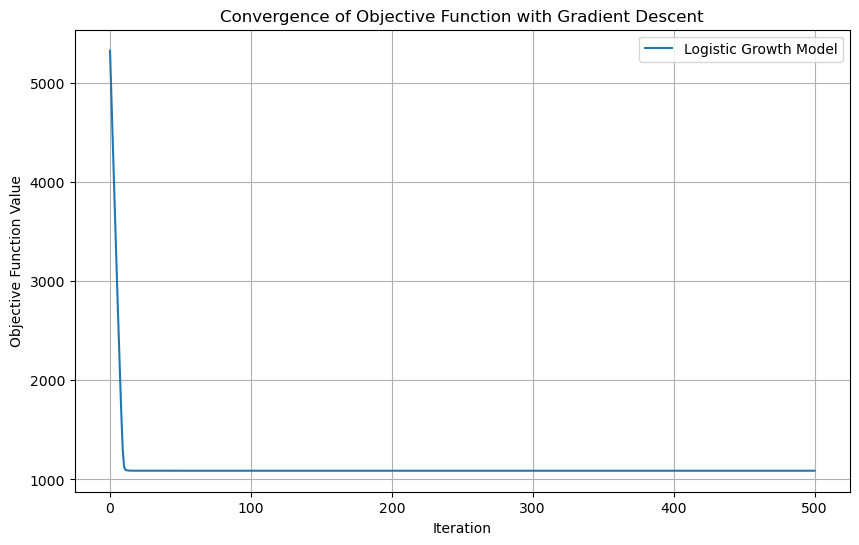

In [157]:
# Plot the convergence of the objective function
plt.figure(figsize=(10, 6))
plt.plot(history_sgls_log, label='Logistic Growth Model')
plt.title('Convergence of Objective Function with Gradient Descent')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()

In [158]:
# Evaluate

# Calculate the predicted population values
P_pred_log = np.zeros(time_steps)
P_pred_log[0] = 10

for t in range(1, time_steps):
    P_pred_log[t] = P_pred_log[t-1] + coeffs_sgls_log[0] * P_pred_log[t-1] * (1 - P_pred_log[t-1] / coeffs_sgls_log[1])
# Metrics
mae_log = mae(P_log, P_pred_log)
mse_log = mse(P_log, P_pred_log)
medad_log = medad(P_log, P_pred_log)
bp_log = breakdown_point(P_log, P_pred_log)

print('\nLogistic Growth Model:')
print(f'MAE: {mae_log:.2f}, MSE: {mse_log:.2f}, MedAD: {medad_log:.2f}, BP: {bp_log:.2f}')


Logistic Growth Model:
MAE: 266.20, MSE: 98755.96, MedAD: 321.30, BP: 0.00


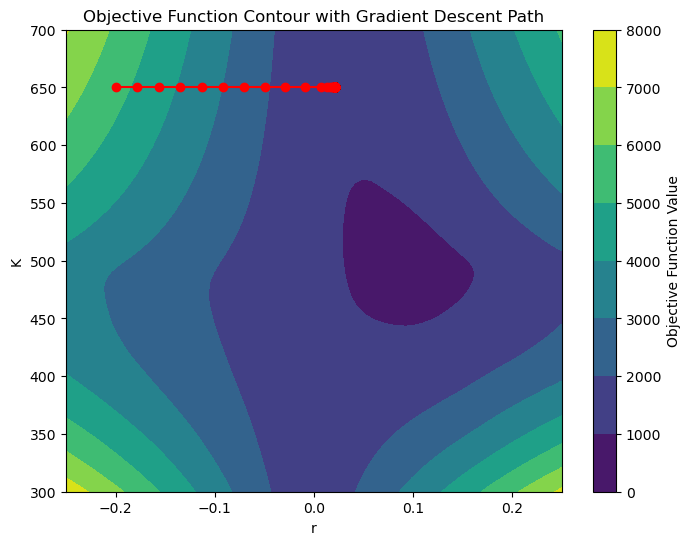

Objective Function Value: 1088.3350


In [159]:
# Plot the path

r_values_log = [param[0] for param in estimates_log]
K_values_log = [param[1] for param in estimates_log]

# Plot the 2D contour
plt.figure(figsize=(8, 6))
contour = plt.contourf(R_smoothed, K_smoothed, Z_smoothed, cmap='viridis')
plt.colorbar(label='Objective Function Value')
plt.plot(r_values_log, K_values_log, '-o', color='red')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Objective Function Contour with Gradient Descent Path')
plt.show()

# Obj function value
print(f'Objective Function Value: {history_sgls_log[-1]:.4f}')


### Trust Region

In [29]:
def advanced_dfo_trns(fun, x0, delta, omega, max_func_evals, iprint):
    """
    Derivative-free trust-region optimization algorithm.

    Parameters:
    fun (callable): The objective function to be minimized.
    x0 (array-like): Initial guess for the optimization variables.
    omega (float): Parameter that multiplies the quadratic term in TR objective.
    max_func_evals (int): Maximum number of allowed function evaluations.
    iprint (int): Printing level (0 - silent, 1 - verbose).

    Returns:
    tuple: Optimized variables, final function value, number of function evaluations, objective function history, coefficients history.
    """

    # Initialization of algorithm parameters
    delta = delta  # Initial trust region radius
    tol_delta = 1e-8  # Tolerance for the trust region radius to stop the algorithm
    eta0 = 0.001  # Lower bound for considering an iteration successful
    eta1 = 0.25  # Upper bound for shrinking the trust region
    eta2 = 0.75  # Lower bound for expanding the trust region
    eta0_n = 1e-8  # Non-smooth model success threshold
    eta1_n = 0.001  # Non-smooth model contraction threshold
    eta2_n = 0.1  # Non-smooth model expansion threshold
    theta = 0.001  # Parameter for the non-smooth model
    pexpon = 0.1  # Exponent parameter for the non-smooth model
    gamma1 = 0.1  # Contraction factor for the trust region radius
    gamma2 = 10 / 9  # Expansion factor for the trust region radius
    epsilon = 1e-6  # Gradient norm threshold to consider as converged
    max_iter = 1000  # Maximum number of iterations

    # Initialization of counters and other variables
    iter = 0  # Iteration counter
    iter_suc = 0  # Successful iteration counter
    func_eval = 0  # Function evaluation counter
    augment = 0  # Augmentation flag to switch between smooth and nonsmooth models

    # History tracking
    history = []  # To track convergence of the objective function values
    path = []  # To track the path of coefficient values

    # Initial point and problem dimension
    x = np.array(x0)
    n = len(x)


    # Initial sample set creation using coordinate perturbations
    Y = np.hstack([x.reshape(-1, 1) + delta * np.eye(n), x.reshape(-1, 1) - delta * np.eye(n)])  # Perturbations
    Y = np.hstack([x.reshape(-1, 1), Y])  # Include the initial point
    f_values = [fun(Y[:, i]) for i in range(Y.shape[1])]  # Evaluate the function at sample points
    func_eval += len(f_values)

    # Initial function value and storing for comparison
    f = f_values[0]  # Initial function value
    fold = f  # Function value at the previous iteration

    # Track the initial function value and coefficients
    history.append(f)
    path.append(x.copy())

    # Printing setup for iteration report
    if iprint > 0:
        print('Iteration Report: \n')
        print('|f eval | success |     f_value     | tr_radius |    rho    |  |Y|  |   ||g||   |   ||s||   |  Delta_f  |')
        print_format = '| %5d |    %2s   | %+13.8e | %+5.2e | %+5.2e | %5d | %+5.2e | %+5.2e | %+5.2e |\n'
        print(print_format % (iter, '--', f, delta, 0, len(f_values), 0, 0, 0))

    # Initialization of the non-smooth model components
    G = np.array([]).reshape(n, 0)  # Matrix for nonsmooth model normals
    betas = np.array([])  # RHS for nonsmooth model

    # Main optimization loop
    stop = False
    while not stop and iter < max_iter and func_eval < max_func_evals:
        success = 0  # Reset success flag for this iteration
        max_red_step = 200 - 10 * (iter // 500)  # Maximum reduction steps based on iterations

        # Check stopping criteria: trust region radius or max function evaluations
        if delta <= tol_delta or func_eval >= max_func_evals:
            stop = True
            continue

        # Build quadratic model using current sample set
        H, g = quad_frob(Y, f_values)  # Compute Hessian (H) and gradient (g) of the quadratic model
        normg = np.linalg.norm(g)  # Compute the norm of the gradient

        # Check gradient norm for stopping criteria
        if normg <= epsilon:
            reduce_delta = max_red_step  # Indicate need to reduce trust region
        else:
            reduce_delta = 0  # Reset reduction step counter

        # Solve the trust region subproblem
        if np.linalg.norm(H, 'fro') > 1e-5:  # If Frobenius norm of the Hessian is not too small
            s, val = trust_region_subproblem(g, H, delta)  # Solve using trust-region method
            if np.linalg.norm(s) > delta + 1e-10:  # Adjust if solution exceeds trust region
                s, val = adjust_trust_solution(g, H, delta)
        else:  # If Frobenius norm of the Hessian is too small, use gradient descent direction
            s = -(delta / normg) * g
            val = np.dot(g, s) + 0.5 * np.dot(s, np.dot(H, s))

        fmin = f + val  # Predicted minimum function value

        # Check if predicted reduction is too small
        if abs(f - fmin) / max(1, abs(f)) < 1e-20:
            reduce_delta = max_red_step

        # Evaluate function at the trial point if reduction is significant
        if reduce_delta < max_red_step:
            x_trial = x + s  # Trial point
            f_trial = fun(x_trial)  # Evaluate function at trial point
            func_eval += 1

            # Calculate actual and predicted reduction
            pred = f - fmin
            actual_reduction = f - f_trial
            rho = actual_reduction / pred if pred != 0 else 0  # Ratio of actual to predicted reduction

            # Update based on the value of rho
            if rho >= eta0:  # Successful iteration
                success = 1
                iter_suc += 1
                x = x_trial  # Update current point
                f = f_trial  # Update current function value
                if rho >= eta2:  # Expand trust region if rho is large enough
                    delta = min(gamma2 * delta, 1e3)
            else:  # Unsuccessful iteration
                if abs(f - fold) < 1e-9 * max(1.0, abs(f)):  # Check for insufficient progress
                    reduce_delta += 1
                if rho < eta1:  # Shrink trust region if rho is too small
                    delta = gamma1 * delta
            if delta < tol_delta:  # Ensure delta does not go below the minimum tolerance
                delta = tol_delta

            if success == 0:  # If iteration was not successful
                augment = 1  # Flag to use nonsmooth model
                delta = 0.9 * delta  # Slightly reduce trust region
            else:
                augment = 0  # No need to use nonsmooth model

            delta_f = abs(f - fold)  # Change in function value

            # Track the history of the objective function and coefficients
            history.append(f)
            path.append(x.copy())

            # Print iteration details
            if iprint > 0:
                print(print_format % (func_eval, success, f, delta, rho, Y.shape[1], normg, np.linalg.norm(s), delta_f))

            iter += 1  # Increment iteration counter
            fold = f  # Update previous function value
            Y, f_values, func_eval = update_sample_set(Y, x, delta, n, fun, f_values, func_eval)  # Update sample set
        else:
            stop = True  # Stop if reduction step counter exceeds maximum

        # Non-smooth model optimization if required
        if augment:
            sol = construct_and_optimize_NS_model(Y, f_values, f, delta, G, betas, omega, theta, pexpon)
            x_trial = x + sol[:n]  # Trial point from nonsmooth model
            f_trial = fun(x_trial)  # Evaluate function at trial point
            func_eval += 1  # Increment function evaluation counter

            rho = (f - f_trial) / (theta * np.linalg.norm(sol[:n])**(1 + pexpon))  # Ratio for nonsmooth model
            if rho >= eta0_n:  # Successful iteration for nonsmooth model
                success = 1
                x = x_trial  # Update current point
                f = f_trial  # Update current function value
                if rho >= eta2_n:  # Expand trust region if rho is large enough
                    delta = min(gamma2 * delta, 1e3)
            else:  # Unsuccessful iteration for nonsmooth model
                delta = 0.9 * delta  # Slightly reduce trust region

    #print("Optimization finished.")
    #print(f"Final function value: {f}")
    #print(f"Function evaluations: {func_eval}")

    return x, f, func_eval, history, path


def quad_frob(Y, f_values):
    """
    Build a quadratic model using Frobenius norm minimization.

    Parameters:
    Y (ndarray): Sample points. Shape (n, m), where n is the dimension of the problem, and m is the number of sample points.
    f_values (list): Function values at sample points. Length should be m.

    Returns:
    tuple: Hessian matrix (H) and gradient (g) of the quadratic model.
    """

    # Tolerance for singular values in SVD
    tol_svd = np.finfo(float).eps**5

    # Dimensions of the problem
    n, m = Y.shape

    # Initialize Hessian (H) and gradient (g) matrices
    H = np.zeros((n, n))
    g = np.zeros(n)

    # Shift sample points to the origin
    Y_shifted = Y - Y[:, [0]]  # Shift all columns by the first column (Y[:, [0]])
    Dmax = np.max(np.sqrt(np.sum(Y_shifted**2, axis=0)))  # Maximum distance from the origin
    Y_shifted /= Dmax  # Normalize the shifted points

    # Case 1: Underdetermined system (fewer equations than unknowns)
    if m < (n + 1) * (n + 2) / 2:
        # Create the extended vector b
        b = np.concatenate([f_values, np.zeros(n + 1)])
        # Construct the matrix A
        A = (Y_shifted.T @ Y_shifted)**2 / 2
        # Construct the augmented matrix W
        W = np.block([
            [A, np.ones((m, 1)), Y_shifted.T],
            [np.ones((1, m)), np.zeros((1, n + 1))],
            [Y_shifted, np.zeros((n, n + 1))]
        ])
        # Perform singular value decomposition (SVD)
        U, S, Vt = np.linalg.svd(W)
        # Regularize small singular values
        S[S < tol_svd] = tol_svd
        Sinv = np.diag(1 / S)  # Inverse of the diagonal matrix of singular values
        # Compute the model coefficients
        lambda_ = Vt.T @ Sinv @ U.T @ b
        # Extract gradient (g) from lambda
        g = lambda_[m + 1:m + n + 1] / Dmax
        # Construct Hessian (H) from lambda
        for j in range(m):
            H += lambda_[j] * np.outer(Y_shifted[:, j], Y_shifted[:, j])
        H /= Dmax**2

    # Case 2: Full quadratic model (sufficient equations)
    else:
        b = np.array(f_values)  # Function values vector
        # Create the quadratic term matrix phi_Q
        phi_Q = []
        for i in range(m):
            y = Y_shifted[:, i]
            aux_H = np.outer(y, y) - 0.5 * np.diag(y**2)
            aux = []
            for j in range(n):
                aux.extend(aux_H[j:n, j])
            phi_Q.append(aux)

        # Construct the matrix W
        W = np.hstack([np.ones((m, 1)), Y_shifted.T, phi_Q])
        # Perform singular value decomposition (SVD)
        U, S, Vt = np.linalg.svd(W, full_matrices=False)
        # Regularize small singular values
        S[S < tol_svd] = tol_svd
        Sinv = np.diag(1 / S)  # Inverse of the diagonal matrix of singular values
        # Compute the model coefficients
        lambda_ = Vt.T @ Sinv @ U.T @ b
        # Extract gradient (g) from lambda
        g = lambda_[1:n + 1] / Dmax
        # Construct Hessian (H) from lambda
        cont = n
        for j in range(n):
            H[j:n, j] = lambda_[cont + 1:cont + n - j + 1]
            cont += n - j
        H = H + H.T - np.diag(np.diag(H))  # Ensure H is symmetric
        H /= Dmax**2

    return H, g



def trust_region_subproblem(g, H, delta):
    """
    Solve the trust-region subproblem to find the step direction and magnitude.

    Parameters:
    g (ndarray): Gradient vector. Shape (n,).
    H (ndarray): Hessian matrix. Shape (n, n).
    delta (float): Trust-region radius.

    Returns:
    tuple: Solution vector (s) and predicted reduction value (val).
    """

    # Define the quadratic model objective function
    def model_obj(s):
        return 0.5 * np.dot(s, np.dot(H, s)) + np.dot(g, s)

    # Define the constraint for the trust-region radius
    constraints = {'type': 'ineq', 'fun': lambda s: delta**2 - np.dot(s, s)}

    # Use a nonlinear optimizer to solve the trust-region subproblem
    result = minimize(model_obj, np.zeros_like(g), constraints=constraints)

    # Check if the optimization was successful
    if result.success:
        # If successful, return the solution vector and the objective value at the solution
        return result.x, model_obj(result.x)
    else:
        # If not successful, return a step in the direction of the negative gradient scaled to the trust region radius
        return -delta * g / np.linalg.norm(g), model_obj(-delta * g / np.linalg.norm(g))


def adjust_trust_solution(g, H, delta):
    """
    Adjust the solution of the trust-region subproblem.

    Parameters:
    g (ndarray): Gradient vector. Shape (n,).
    H (ndarray): Hessian matrix. Shape (n, n).
    delta (float): Trust-region radius.

    Returns:
    tuple: Adjusted solution vector (s) and predicted reduction value (val).
    """

    # Compute the norm of the gradient vector
    normg = np.linalg.norm(g)

    # Check if the Hessian curvature in the gradient direction is positive
    if g.T @ H @ g > 0:
        # Compute the optimal step length in the gradient direction
        alfastar = (g.T @ g) / (g.T @ H @ g)
        # Check if the computed step is within the trust-region radius
        if np.linalg.norm(alfastar * g) <= delta:
            # If within the trust-region, compute the step and its predicted reduction
            s = -alfastar * g
            val = np.dot(g, s) + 0.5 * np.dot(s, np.dot(H, s))
        else:
            # If outside the trust-region, scale the step to lie on the trust-region boundary
            alfastar = delta / normg
            s = -alfastar * g
            val = np.dot(g, s) + 0.5 * np.dot(s, np.dot(H, s))
    else:
        # If Hessian curvature is not positive, use a scaled gradient step on the trust-region boundary
        alfastar = delta / normg
        s = -alfastar * g
        val = np.dot(g, s) + 0.5 * np.dot(s, np.dot(H, s))

    return s, val


def update_sample_set(Y, x, delta, n, fun, f_values, func_eval):
    """
    Update the sample set using the Halton sequence for the next iteration.

    Parameters:
    Y (ndarray): Current sample points. Shape (n, m), where n is the dimension of the problem, and m is the number of sample points.
    x (ndarray): Current best point. Shape (n,).
    delta (float): Trust-region radius.
    n (int): Dimension of the optimization problem.
    fun (callable): Objective function to be minimized.
    f_values (list): Current function values at sample points. Length should be m.
    func_eval (int): Current function evaluation count.

    Returns:
    tuple: Updated sample points (Y), updated function values (f_values), and updated function evaluation count (func_eval).
    """

    # Shift the sample points relative to the current best point
    Y_shifted = Y - x[:, None]  # Shift each column of Y by the vector x

    # Calculate the norms of the shifted points
    if n > 1:
        Ynorms = np.sqrt(np.sum(Y_shifted**2, axis=0))  # Euclidean norms
    else:
        Ynorms = np.abs(Y_shifted)  # Absolute values for 1D case

    # Define the maximum radius for points to be considered
    raggio = min(delta, 10.0)

    # Find indices of points within the defined radius but not too close to the origin
    indices = np.where((Ynorms <= raggio) & (Ynorms > 1e-7))[0]

    # If there are not enough valid points, regenerate the sample set
    if len(indices) == 0 or len(indices) <= 1:
        npmax = max(3, n // 3)  # Maximum number of new points to generate
        Y = x[:, None]  # Reset sample set to include only the current best point
        f_values = [fun(x)]  # Evaluate the function at the current best point
        func_eval += 1

        # Generate new sample points using the Halton sequence
        for _ in range(npmax):
            d = -1 + 2 * qmc.Halton(d=n).random(n=1).T  # Generate a random direction
            d = d / np.linalg.norm(d) * 0.5 * raggio  # Normalize and scale the direction
            x_trial = x + d.squeeze()  # New trial point
            f_trial = fun(x_trial)  # Evaluate the function at the trial point
            Y = np.hstack([Y, x_trial[:, None]])  # Add the trial point to the sample set
            f_values.append(f_trial)  # Append the function value to the list
            func_eval += 1

    # Generate new points around the current best point for the next iteration
    new_points = np.hstack([x.reshape(-1, 1) + delta * np.eye(n), x.reshape(-1, 1) - delta * np.eye(n)])
    Y = np.hstack([x.reshape(-1, 1), new_points])  # Update the sample set
    f_values = [fun(Y[:, i]) for i in range(Y.shape[1])]  # Evaluate the function at the new sample points
    func_eval += len(f_values)  # Increment function evaluation count by the number of new points

    return Y, f_values, func_eval


def construct_and_optimize_NS_model(Y, f_values, fval, delta, G, betas, omega, theta, pexpon):
    """
    Construct and optimize the nonsmooth model.

    Parameters:
    Y (ndarray): Sample points. Shape (n, m), where n is the dimension of the problem and m is the number of sample points.
    f_values (list): Function values at sample points. Length should be m.
    fval (float): Current function value at the best point.
    delta (float): Trust-region radius.
    G (ndarray): Matrix whose columns are normals of hyperplanes used to build the nonsmooth model.
    betas (ndarray): Vector whose elements are rhs's of hyperplanes for the nonsmooth model.
    omega (float): Parameter that multiplies the quadratic term in TR objective.
    theta (float): Parameter for the nonsmooth model.
    pexpon (float): Exponent parameter for the nonsmooth model.

    Returns:
    ndarray: Solution vector from optimizing the nonsmooth model.
    """

    #print("NS bundle model is constructed")

    n = Y.shape[0]  # Dimension of the problem
    nC = 10  # Number of new directions to be added to G

    # Generate new directions using Halton sequence
    Gt = -1 + 2 * qmc.Halton(d=n).random(n=nC).T
    Gt /= np.linalg.norm(Gt, axis=0)  # Normalize the new directions
    G = np.hstack([G, Gt])  # Append new directions to G
    nG = G.shape[1]  # Number of columns in G (total number of directions)

    # Shift sample points relative to the first point in Y
    S = Y - Y[:, [0]]
    Ynorms = np.linalg.norm(S, axis=0)  # Norms of the shifted points

    # Calculate the betas for the nonsmooth model
    betas = np.maximum(0, np.max(-(f_values - fval - G.T @ S - 1e-5 * Ynorms), axis=1))
    tildebetas = betas.copy()
    tildebetas[:-nC] += np.sqrt(delta)  # Adjust betas for the new directions

    # Build quadratic model using current sample set
    H, g = quad_frob(Y, f_values)  # Compute Hessian (H) and gradient (g)

    # Construct the quadratic term for the model
    if np.linalg.norm(H, 'fro') > 1e-5:  # Check if Hessian norm is significant
        lambda_ = np.linalg.eigvals(H)  # Eigenvalues of the Hessian
        if np.min(lambda_) > 1e-6 and np.max(lambda_) < 1e5:  # Check eigenvalue bounds
            Q = np.block([[H, np.zeros((n, 1))], [np.zeros((1, n+1))]])  # Use Hessian for Q
        else:
            Q = np.block([[0.5 * min(100, 1 / np.sqrt(delta)) * np.eye(n), np.zeros((n, 1))], [np.zeros((1, n+1))]])  # Regularize Q
    else:
        Q = np.block([[0.5 * min(100, 1 / np.sqrt(delta)) * np.eye(n), np.zeros((n, 1))], [np.zeros((1, n+1))]])  # Regularize Q for small Hessian

    Q = omega * Q  # Scale Q by omega
    flin = np.zeros(n + 1)
    flin[-1] = 1  # Linear term in the objective function

    # Construct the constraints for the optimization problem
    A = np.hstack([G.T, -np.ones((nG, 1))])  # Constraint matrix
    b = -fval + tildebetas  # Right-hand side of the constraints

    # Initial guess for the optimization
    x0_ns = np.hstack([Y[:, 0], fval])  # Initial point and function value

    # Solve the quadratic programming problem
    sol = minimize(lambda x: 0.5 * np.dot(x, np.dot(Q, x)) + np.dot(flin, x), x0_ns, constraints={'type': 'ineq', 'fun': lambda x: b - np.dot(A, x)}).x

    return sol



#### Linear Population Dynamics Model

In [1197]:
omega = 0.5
MAXNF = 10000
iprint = 0
delta = 1.0

initial_guess = [-0.8, 20]
lad_obj = lambda params: lad_objective(params, P_gaussian, X_gaussian)

final_coefs, final_obj, fun_eval, hist_trust, path_trust = advanced_dfo_trns(lad_obj, initial_guess, delta, omega, MAXNF, iprint)

print("Optimized Parameters:", final_coefs)
print("Optimized Obj. Value:", final_obj)
print("Obj. fun. eval:", fun_eval)


Optimized Parameters: [ 0.12796632 11.55505598]
Optimized Obj. Value: 329.74012188019503
Obj. fun. eval: 3926


Num. of iterations: 402


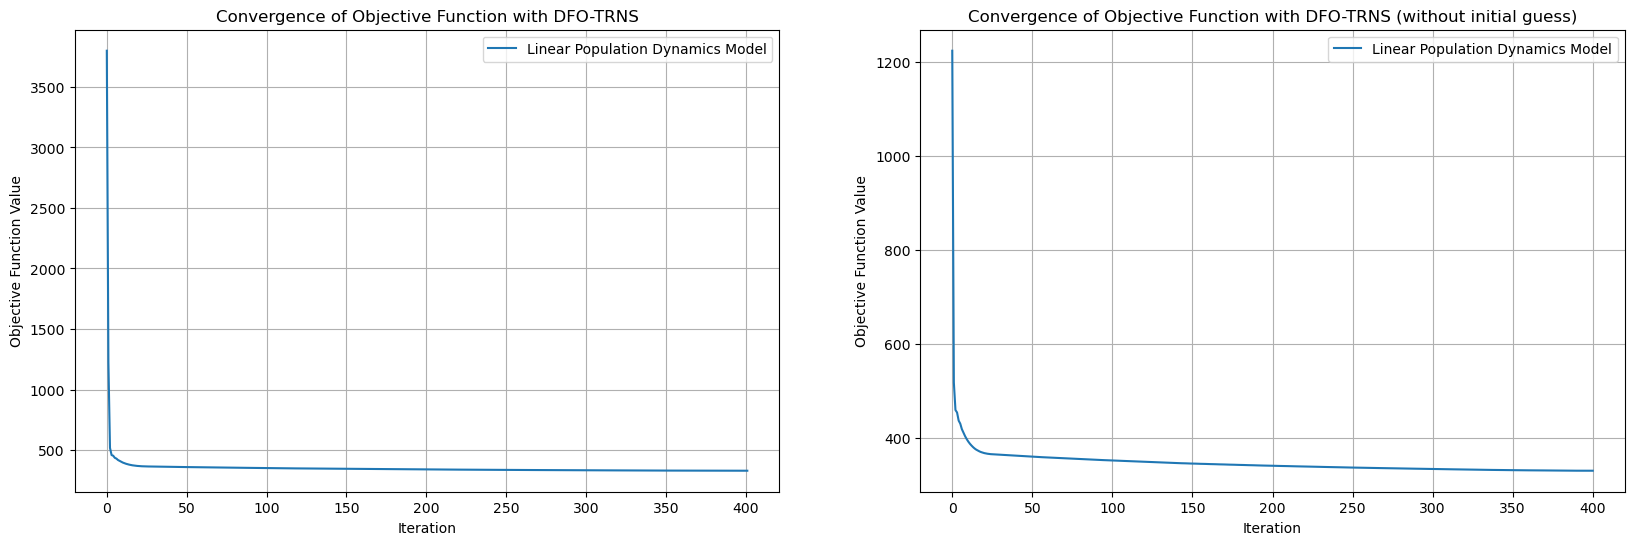

In [1198]:
# Plot the objective function convergence

print("Num. of iterations:", len(hist_trust))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot on the first subplot
ax1.plot(hist_trust, label='Linear Population Dynamics Model')
ax1.set_title('Convergence of Objective Function with DFO-TRNS')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective Function Value')
ax1.legend()
ax1.grid(True)

# Plot on the second subplot, starting from the first element
ax2.plot(hist_trust[1:], label='Linear Population Dynamics Model')
ax2.set_title('Convergence of Objective Function with DFO-TRNS (without initial guess)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective Function Value')
ax2.legend()
ax2.grid(True)

# Show the plots
plt.show()

In [1199]:
# Evaluate

#print("Final coefs.:", final_coefs)

# Calculate the predicted population values
P_pred_gaussian = X_gaussian @ final_coefs[::-1]

mae_gaussian = mae(P_gaussian, P_pred_gaussian)
mse_gaussian = mse(P_gaussian, P_pred_gaussian)
medad_gaussian = medad(P_gaussian, P_pred_gaussian)
bp_gaussian = breakdown_point(P_gaussian, P_pred_gaussian)

print('Linear Population Dynamics Model:')
print(f'MAE: {mae_gaussian:.2f}, MSE: {mse_gaussian:.2f}, MedAD: {medad_gaussian:.2f}, BP: {bp_gaussian:.2f}')

Linear Population Dynamics Model:
MAE: 3.30, MSE: 17.01, MedAD: 2.64, BP: 0.76


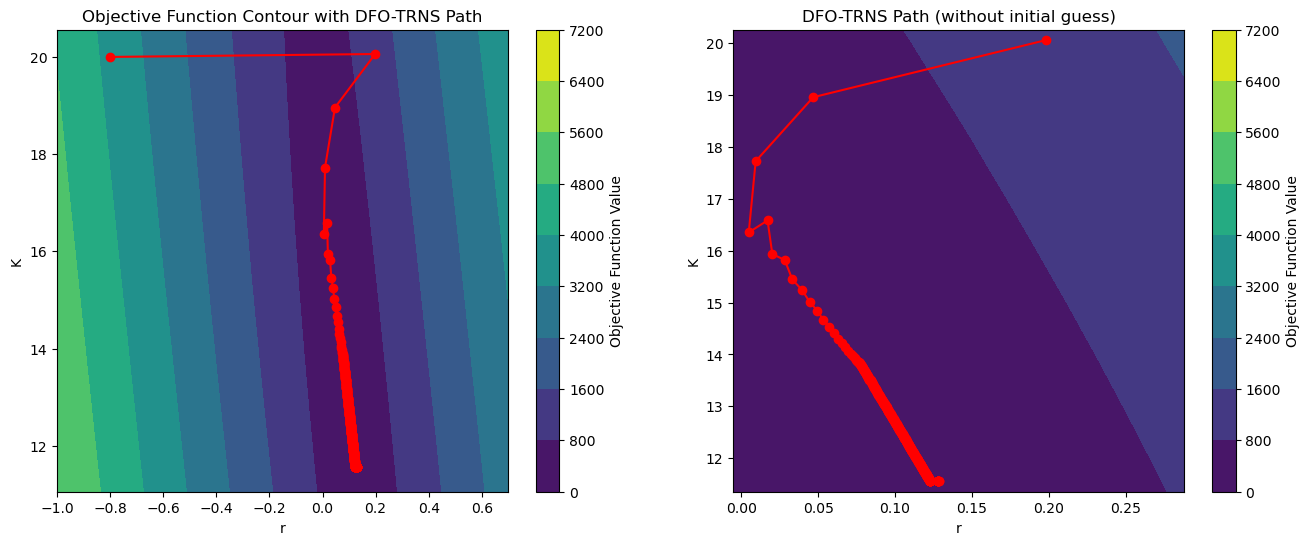

Objective Function Value: 329.7401


In [1202]:
# Path on the obj contour

r_values = [param[0] for param in path_trust]
K_values = [param[1] for param in path_trust]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Contour plot on the first subplot
contour1 = ax1.contourf(R, K, Z, cmap='viridis')
fig.colorbar(contour1, ax=ax1, label='Objective Function Value')
ax1.plot(r_values, K_values, '-o', color='red')
ax1.set_xlim(min(r_values) - 0.2, max(r_values) + 0.5)
ax1.set_ylim(min(K_values) - 0.5, max(K_values) + 0.5)
ax1.set_xlabel('r')
ax1.set_ylabel('K')
ax1.set_title('Objective Function Contour with DFO-TRNS Path')

# Contour plot on the second subplot
contour2 = ax2.contourf(R, K, Z, cmap='viridis')
fig.colorbar(contour2, ax=ax2, label='Objective Function Value')
ax2.plot(r_values[1:], K_values[1:], '-o', color='red')
ax2.set_xlim(min(r_values[1:]) - 0.01, max(r_values[1:]) + 0.09)
ax2.set_ylim(min(K_values[1:]) - 0.2, max(K_values[1:]) + 0.2)
ax2.set_xlabel('r')
ax2.set_ylabel('K')
ax2.set_title('DFO-TRNS Path (without initial guess)')

# Show the plots
plt.show()

# Print the last objective function value
print(f'Objective Function Value: {hist_trust[-1]:.4f}')




#### Logistic Growth Model

In [72]:
# Test on Logistic Growth Model

# Initial guess r and K
initial_guess = [-0.2, 650]

omega = 1.0
MAXNF = 10000
iprint = 0
delta = 100

lad_obj_log = lambda params: lad_objective_log(params, P_log, time_steps)

final_coefs_log, final_obj_log, fun_eval_log, hist_trust_log, path_trust_log = advanced_dfo_trns(lad_obj_log, initial_guess, delta, omega, MAXNF, iprint)

print("Optimized Parameters:", final_coefs_log)
print("Optimized Obj. Value:", final_obj_log)
print("Obj. fun. eval:", fun_eval_log)


Optimized Parameters: [1.01712516e-01 4.95481414e+02]
Optimized Obj. Value: 377.81464248037605
Obj. fun. eval: 879


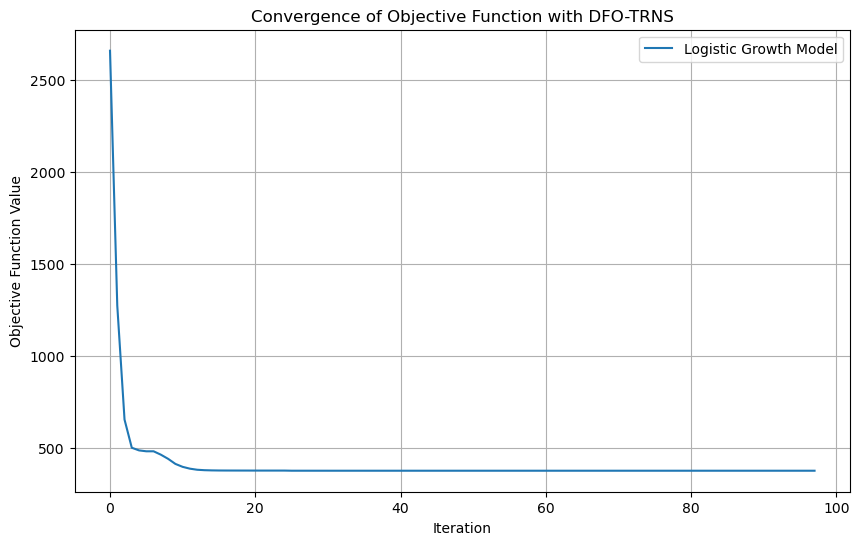

In [73]:
# Plot the convergence of the objective function

plt.figure(figsize=(10, 6))
plt.plot(hist_trust_log, label='Logistic Growth Model')
plt.title('Convergence of Objective Function with DFO-TRNS')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()


In [74]:
# Evaluate

# Calculate the predicted population values
P_pred_log = np.zeros(time_steps)
P_pred_log[0] = 10

estimated_r_log, estimated_K_log = final_coefs_log

for t in range(1, time_steps):
    P_pred_log[t] = P_pred_log[t-1] + estimated_r_log * P_pred_log[t-1] * (1 - P_pred_log[t-1] / estimated_K_log)

mae_log = mae(P_log, P_pred_log)
mse_log = mse(P_log, P_pred_log)
medad_log = medad(P_log, P_pred_log)
bp_log = breakdown_point(P_log, P_pred_log)

print('Logistic Growth Model:')
print(f'MAE: {mae_log:.2f}, MSE: {mse_log:.2f}, MedAD: {medad_log:.2f}, BP: {bp_log:.2f}')


Logistic Growth Model:
MAE: 8.44, MSE: 146.13, MedAD: 3.68, BP: 0.59


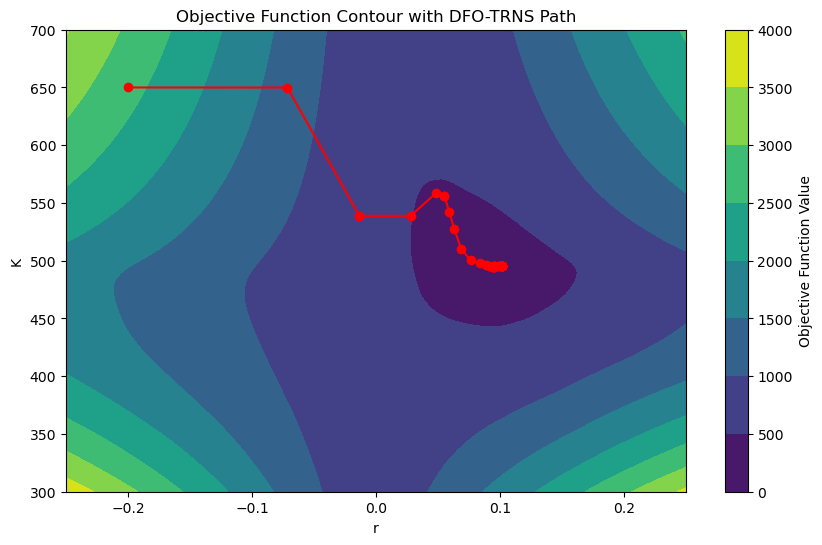

Objective Function Value: 377.8146


In [75]:
# Plot the path on the objective function contour

r_values_log = [param[0] for param in path_trust_log]
K_values_log = [param[1] for param in path_trust_log]

# One plot
plt.figure(figsize=(10, 6))
plt.contourf(R, K, Z, cmap='viridis')
plt.colorbar(label='Objective Function Value')
plt.plot(r_values_log, K_values_log, '-o', color='red')
#plt.xlim(min(r_values_log) - 0.1, max(r_values_log) + 0.1)
#plt.ylim(min(K_values_log) - 50, max(K_values_log) + 50)
plt.xlabel('r')
plt.ylabel('K')
plt.title('Objective Function Contour with DFO-TRNS Path')
plt.show()

# Print the last objective function value
print(f'Objective Function Value: {hist_trust_log[-1]:.4f}')


# State-of-the-art algorithms

1. Iteratively re-weighted least squares (IRLS)
2. Wesolowsky’s direct descent method
3. Li-Arce’s maximum likelihood approach

### Iteratively re-weighted least squares (IRLS)

In [1039]:
def irls(X, y, iterations=100, tol=1e-5, initial_guess=None):
    n_samples, n_features = X.shape
    weights = np.ones(n_samples)  # Initialize weights to 1

    history = []  # To track convergence of the objective function values
    path = []  # To track the path of coefficient values
    func_evals = 0  # Initialize function evaluation counter (residual calculation)

    # Initialize coefficients with the initial guess if provided, otherwise zeros
    if initial_guess is not None and len(initial_guess) == n_features:
        beta = np.array(initial_guess)
        path.append(beta)
        objective_value = np.sum(np.abs(y - X @ beta))
        history.append(objective_value)
    else:
        beta = np.zeros(n_features)

    for _ in range(iterations):
        W = np.diag(weights)  # Weight matrix for this iteration
        # Update coefficients using weighted least squares
        beta_new = pinv(X.T @ W @ X) @ X.T @ W @ y
        # Calculate residuals
        residuals = y - X @ beta_new
        func_evals += 1
        # Calculate the objective function value
        objective_value = np.sum(np.abs(residuals))
        history.append(objective_value)
        path.append(beta_new)
        # Update weights based on residuals
        weights = 1 / (np.abs(residuals) + np.finfo(float).eps)  # Prevent division by zero

        # Check for convergence
        delta_beta = np.linalg.norm(beta_new - beta)
        if delta_beta < tol:
            break

        beta = beta_new  # Update coefficients for next iteration

    return beta, history, path, func_evals


In [94]:
# Test

initial_guess=[20, -0.8]
coeffs_irls_lin_pop, history_lin_pop, path_lin_pop, fun_eval = irls(X_gaussian, P_gaussian, initial_guess=initial_guess)

print('\nLinear Population Dynamics Model:')
print(coeffs_irls_lin_pop)
print(f'Function evaluations: {fun_eval}')


Linear Population Dynamics Model:
[10.57512195  0.14468067]
Function evaluations: 10


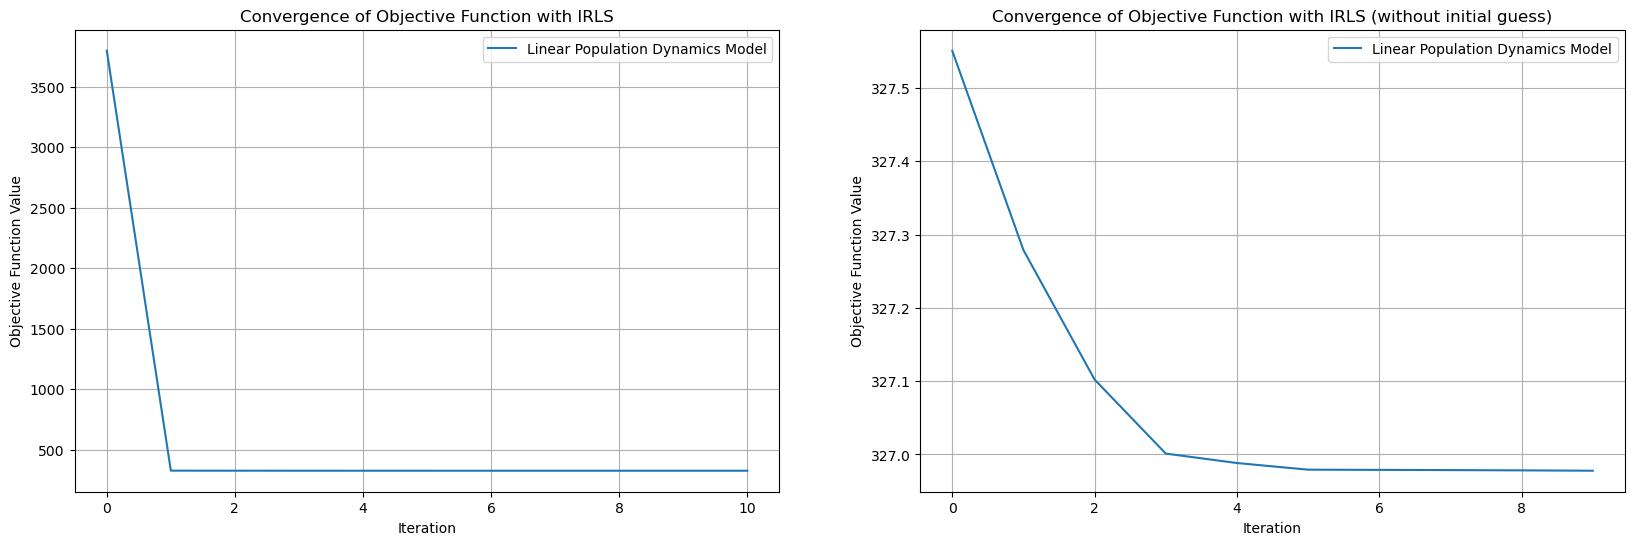

In [95]:
# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot on the first subplot
ax1.plot(history_lin_pop, label='Linear Population Dynamics Model')
ax1.set_title('Convergence of Objective Function with IRLS')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective Function Value')
ax1.legend()
ax1.grid(True)

# Plot on the second subplot, starting from the first element
ax2.plot(history_lin_pop[1:], label='Linear Population Dynamics Model')
ax2.set_title('Convergence of Objective Function with IRLS (without initial guess)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective Function Value')
ax2.legend()
ax2.grid(True)

# Show the plots
plt.show()

In [96]:
# Evaluate the performance of the IRLS

# Linear Population Dynamics Model
P_pred_gaussian = X_gaussian @ coeffs_irls_lin_pop
# Metrics
mae_lin_pop = mae(P_gaussian, P_pred_gaussian)
mse_lin_pop = mse(P_gaussian, P_pred_gaussian)
medad_lin_pop = medad(P_gaussian, P_pred_gaussian)
bp_lin_pop = breakdown_point(P_gaussian, P_pred_gaussian)


print(f'MAE: {mae_lin_pop:.2f}, MSE: {mse_lin_pop:.2f}, MedAD: {medad_lin_pop:.2f}, BP: {bp_lin_pop:.2f}')

MAE: 3.27, MSE: 16.78, MedAD: 2.80, BP: 0.81


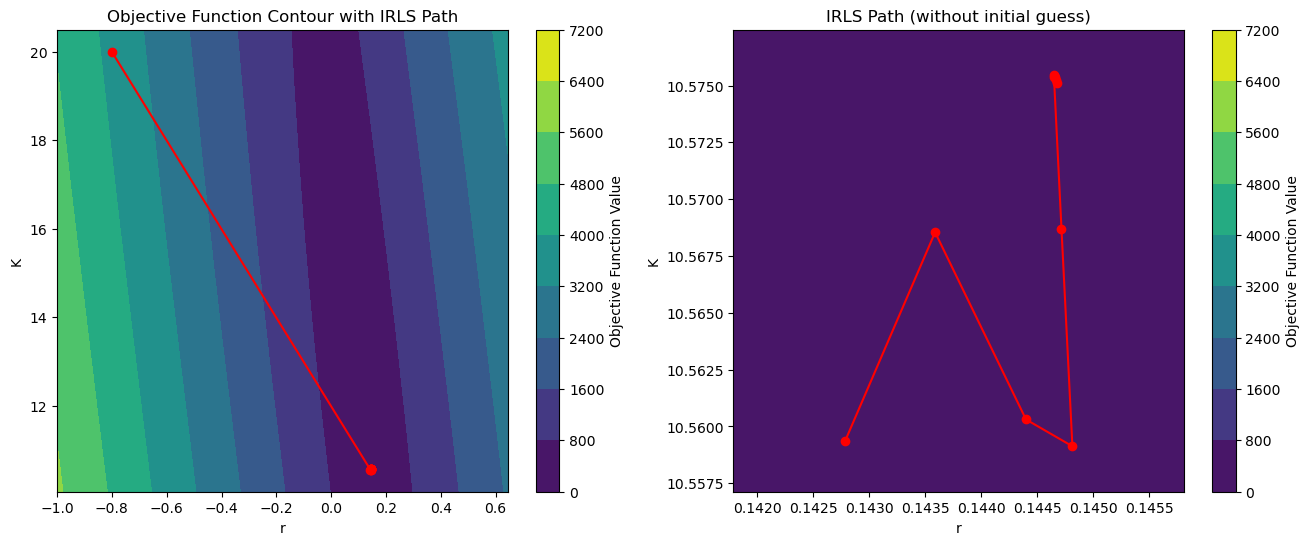

Objective Function Value: 326.9778


In [97]:
# Plot the path

#print(path_lin_pop)

r_values = [param[1] for param in path_lin_pop]
K_values = [param[0] for param in path_lin_pop]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Contour plot on the first subplot
contour1 = ax1.contourf(R, K, Z, cmap='viridis')
fig.colorbar(contour1, ax=ax1, label='Objective Function Value')
ax1.plot(r_values, K_values, '-o', color='red')
ax1.set_xlim(min(r_values) - 0.2, max(r_values) + 0.5)
ax1.set_ylim(min(K_values) - 0.5, max(K_values) + 0.5)
ax1.set_xlabel('r')
ax1.set_ylabel('K')
ax1.set_title('Objective Function Contour with IRLS Path')

# Contour plot on the second subplot
contour2 = ax2.contourf(R, K, Z, cmap='viridis')
fig.colorbar(contour2, ax=ax2, label='Objective Function Value')
ax2.plot(r_values[1:], K_values[1:], '-o', color='red')
ax2.set_xlim(min(r_values[1:]) - 0.001, max(r_values[1:]) + 0.001)
ax2.set_ylim(min(K_values[1:]) - 0.002, max(K_values[1:]) + 0.002)
ax2.set_xlabel('r')
ax2.set_ylabel('K')
ax2.set_title('IRLS Path (without initial guess)')

# Show the plots
plt.show()

# Print the last objective function value
print(f'Objective Function Value: {history_lin_pop[-1]:.4f}')

### Wesolowsky’s direct descent method

In [1049]:
def weighted_median(data, weights):
    sorter = np.argsort(data)
    data_sorted = data[sorter]
    weights_sorted = weights[sorter]
    cum_weights = np.cumsum(weights_sorted)
    midpoint = 0.5 * cum_weights[-1]
    idx = np.searchsorted(cum_weights, midpoint)
    return data_sorted[idx], sorter[idx]

def wesolowsky_descent(X, Y, initial_guess=None, max_iter=100, tol=1e-5, epsilon=1e-10):

    history = []
    path = []

    # Initialize a and b from initial_guess or based on median calculations
    if initial_guess is None:
        a = np.median(Y / (X+epsilon))
        b = np.median(Y - a * (X+epsilon))
    else:
        a = initial_guess[0]
        b = initial_guess[1]

    j = np.argmin(np.abs(Y - a * X - b))

    path.append([a, b])
    history.append(np.sum(np.abs(Y - (a * X + b))))

    for k in range(max_iter):
        X_safe = X + epsilon  # Prevent division by zero

        weights = np.abs(1 - X / X_safe[j])
        terms = (Y - Y[j] * X / X_safe[j]) / (1 - X / X_safe[j])
        b_new, i = weighted_median(terms, weights)

        residuals = Y - (a * X + b_new)
        history.append(np.sum(np.abs(residuals)))
        path.append([a, b_new])

        if k > 2 and np.abs(b_new - b) < tol:  # Convergence check
            b = b_new
            j = i  # Update j based on the weighted median index

            # Final calculations for a and b based on the last j
            b_star = b
            a_star = Y[j] / X[j] - b_star / X[j]
            path.append([a_star, b_star])
            residuals_final = Y - (a_star * X + b_star)
            history.append(np.sum(np.abs(residuals_final)))

            return np.array([a_star, b_star]), history, np.array(path)

        b = b_new
        j = i  # Update j to the index of the new weighted median

    return np.array([a, b]), history, np.array(path)

In [364]:
# Test on the linear population dynamics model
initial_guess = [-0.8, 20]
estimates_wesolowsky, history_wesolowsky, path_wesolowsky = wesolowsky_descent(X_gaussian[:, 1], P_gaussian, initial_guess)

a, b = estimates_wesolowsky

print("Linear Population Dynamics Model:")
print(f'a: {a:.4f}, b: {b:.4f}')

Linear Population Dynamics Model:
a: 0.1448, b: 10.5741


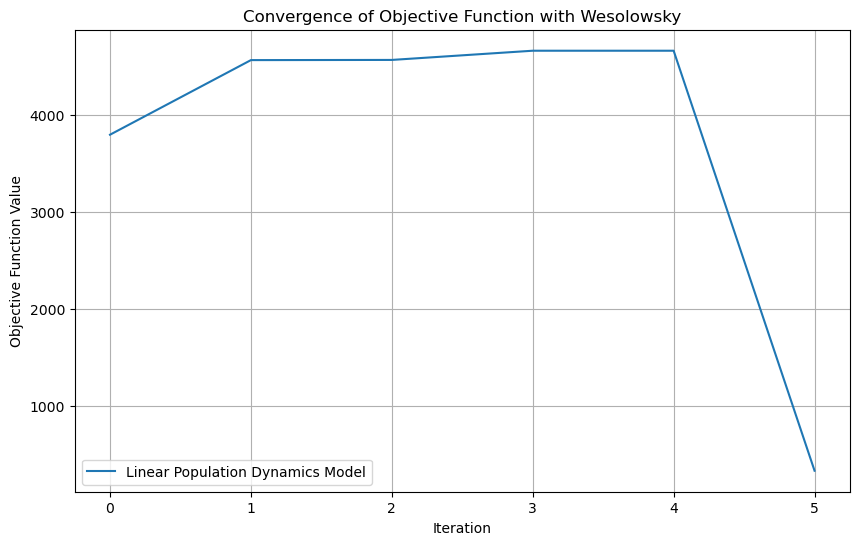

In [365]:
# Plotting convergence of the objective function values
plt.figure(figsize=(10, 6))
plt.plot(history_wesolowsky, label='Linear Population Dynamics Model')
plt.title('Convergence of Objective Function with Wesolowsky')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()

In [366]:
# Evaluate the performance of the Wesolowsky algorithm on the linear population dynamics model

# Calculate the predicted population values
P_pred_gaussian = a * X_gaussian[:, 1] + b
# Metrics
mae_gaussian = mae(P_gaussian, P_pred_gaussian)
mse_gaussian = mse(P_gaussian, P_pred_gaussian)
medad_gaussian = medad(P_gaussian, P_pred_gaussian)
bp_gaussian = breakdown_point(P_gaussian, P_pred_gaussian)

print('Linear Population Dynamics Model:')
print(f'MAE: {mae_gaussian:.2f}, MSE: {mse_gaussian:.2f}, MedAD: {medad_gaussian:.2f}, BP: {bp_gaussian:.2f}')

Linear Population Dynamics Model:
MAE: 3.27, MSE: 16.78, MedAD: 2.80, BP: 0.81


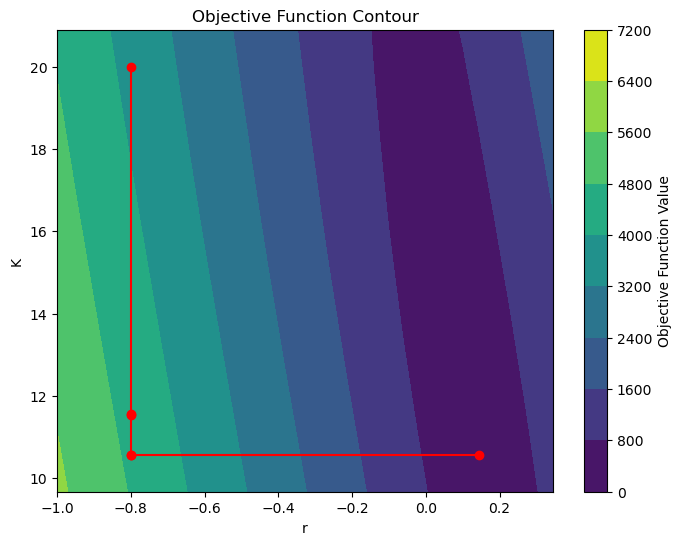

Objective Function Value: 326.9738


In [367]:
# Plot the path

#print(path_wesolowsky)

a_values = [param[0] for param in path_wesolowsky]
b_values = [param[1] for param in path_wesolowsky]

# Plot the 2D contour
plt.figure(figsize=(8, 6))
plt.contourf(R, K, Z, cmap='viridis')
plt.colorbar(label='Objective Function Value')
plt.xlabel('r')
plt.ylabel('K')
plt.title('Objective Function Contour')

# Plot the Wesolowsky path
plt.plot(a_values, b_values, '-o', color='red')

# Set the x and y axis limits to zoom in
plt.xlim(min(a_values) - 0.2, max(a_values) + 0.2)
plt.ylim(min(b_values) - 0.9, max(b_values) + 0.9)

#plt.grid(True)
plt.show()

# Obj function value
print(f'Objective Function Value: {history_wesolowsky[-1]:.4f}')

### Li-Arce’s maximum likelihood approach

In [1051]:
def weighted_median(data, weights):
    sorter = np.argsort(data)
    data_sorted = data[sorter]
    weights_sorted = weights[sorter]
    cum_weights = np.cumsum(weights_sorted)
    midpoint = 0.5 * cum_weights[-1]
    return data_sorted[np.searchsorted(cum_weights, midpoint)]

def initialize_b0(X, Y):
    """Initialize b0 using the least squares solution."""
    X_bar = np.mean(X)
    Y_bar = np.mean(Y)
    numerator = np.sum((X - X_bar) * (Y - Y_bar))
    denominator = np.sum((X - X_bar)**2)
    b0 = numerator / denominator
    return b0

def li_arce(X, Y, tol=1e-5, max_iter=100, epsilon=1e-10, initial_guess=None):

    N = len(X)

    # Use initial guess if provided, otherwise initialize b0 using the least squares solution
    if initial_guess is not None:
        a, b = initial_guess
    else:
        b = initialize_b0(X, Y)
        # Calculate a0 by a weighted median
        a = weighted_median((Y / (X + epsilon)) - b / (X + epsilon), np.abs(X + epsilon))

    j = np.argmin(np.abs(a - (Y - b) / (X + epsilon)))

    history = []  # To store objective function values
    path = []  # To store the path of parameter estimates

    history.append(np.sum(np.abs(Y - (X * a + b))))
    path.append([a, b])

    for k in range(max_iter):
        # Shift coordinates in the sample space
        X_prime = X - X[j] + epsilon  # Avoid division by zero
        Y_prime = Y

        # Calculate transformed parameters
        b_prime = b + a * (X[j] + epsilon)

        # Perform a weighted median to get a new estimate of a
        a_prime = weighted_median((Y_prime - b_prime) / X_prime, np.abs(X_prime))

        # Transform back to the original coordinates
        a_new = a_prime
        b_new = b_prime - a_prime * X[j]

        # Calculate the objective function value
        residuals = Y - (X * a_new + b_new)
        objective_value = np.sum(np.abs(residuals))
        history.append(objective_value)
        path.append([a_new, b_new])

        # Update the index j for the next iteration
        j = np.argmin(np.abs(a_prime - (Y_prime - b_prime) / X_prime))

        # Convergence check
        if np.abs(a_new - a) < tol and np.abs(b_new - b) < tol:
            break

        a, b = a_new, b_new

    return np.array([a, b]), history, np.array(path)

In [371]:
# Test on the linear population dynamics model
initial_guess = [-0.8, 20]
estimates_li_arce, history_li_arce, path_li_arce = li_arce(X_gaussian[:, 1], P_gaussian, initial_guess=initial_guess)

a, b = estimates_li_arce

print("Linear Population Dynamics Model:")
print(f'a: {a:.4f}, b: {b:.4f}')


Linear Population Dynamics Model:
a: 0.1448, b: 10.5741


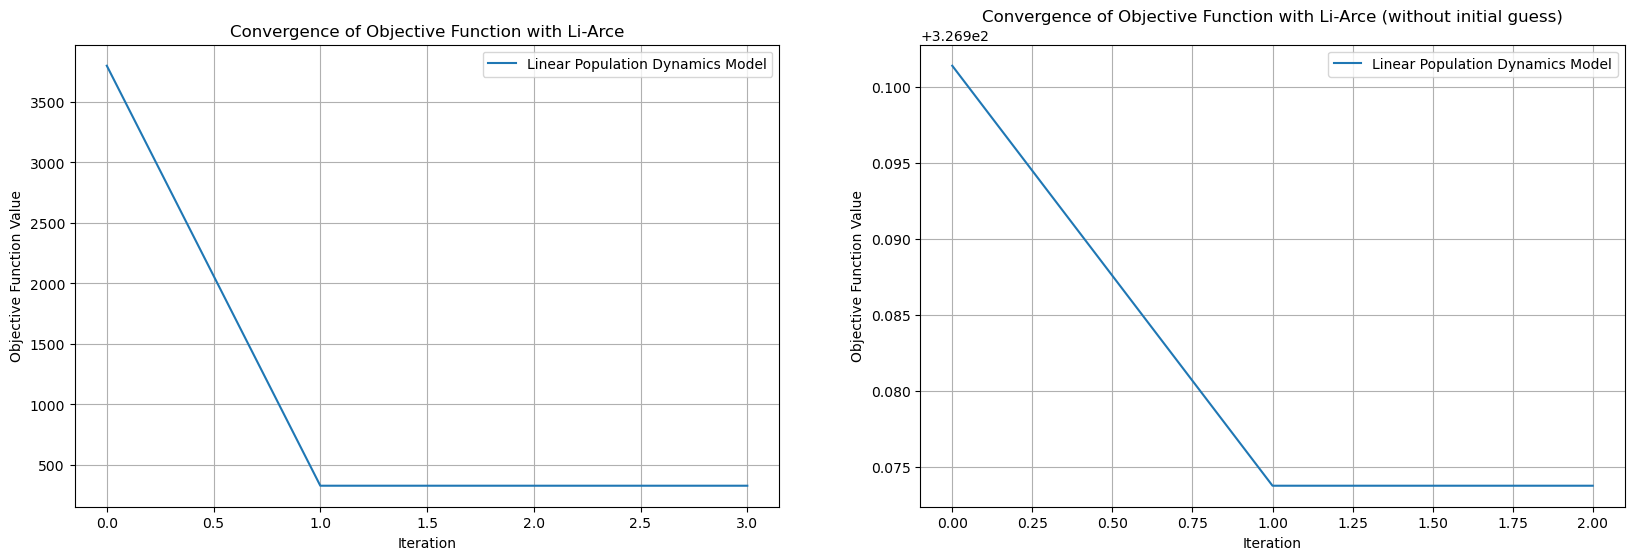

Objective Function Values: [3798.622635691555, 327.0014048867789, 326.9737565677876, 326.97375656777916]


In [372]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot on the first subplot
ax1.plot(history_li_arce, label='Linear Population Dynamics Model')
ax1.set_title('Convergence of Objective Function with Li-Arce')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective Function Value')
ax1.legend()
ax1.grid(True)

# Plot on the second subplot, starting from the first element
ax2.plot(history_li_arce[1:], label='Linear Population Dynamics Model')
ax2.set_title('Convergence of Objective Function with Li-Arce (without initial guess)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective Function Value')
ax2.legend()
ax2.grid(True)

plt.show()

print(f'Objective Function Values: {history_li_arce}')

In [373]:
# Evaluate the performance of the Li-Arce

# Calculate the predicted population values
P_pred_gaussian = a * X_gaussian[:, 1] + b
# Metrics
mae_gaussian = mae(P_gaussian, P_pred_gaussian)
mse_gaussian = mse(P_gaussian, P_pred_gaussian)
medad_gaussian = medad(P_gaussian, P_pred_gaussian)
bp_gaussian = breakdown_point(P_gaussian, P_pred_gaussian)

print('Linear Population Dynamics Model:')
print(f'MAE: {mae_gaussian:.2f}, MSE: {mse_gaussian:.2f}, MedAD: {medad_gaussian:.2f}, BP: {bp_gaussian:.2f}')

Linear Population Dynamics Model:
MAE: 3.27, MSE: 16.78, MedAD: 2.80, BP: 0.81


[[-0.8        20.        ]
 [ 0.14514119 10.54858812]
 [ 0.14477739 10.57405368]
 [ 0.14477739 10.57405368]]


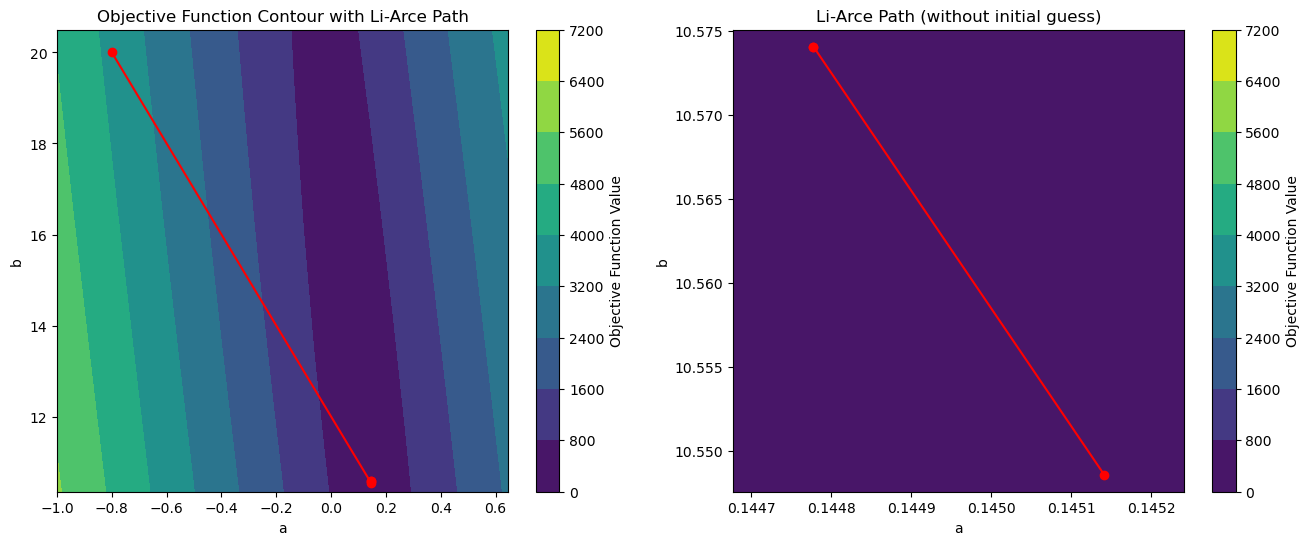

Objective Function Value: 326.9738


In [374]:
# Plot the path

#print(path_li_arce)

a_values = [param[0] for param in path_li_arce]
b_values = [param[1] for param in path_li_arce]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Contour plot on the first subplot
contour1 = ax1.contourf(R, K, Z, cmap='viridis')
fig.colorbar(contour1, ax=ax1, label='Objective Function Value')
ax1.plot(a_values, b_values, '-o', color='red')
ax1.set_xlim(min(a_values) - 0.2, max(a_values) + 0.5)
ax1.set_ylim(min(b_values) - 0.2, max(b_values) + 0.5)
ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title('Objective Function Contour with Li-Arce Path')

# Contour plot on the second subplot, starting from the first element
contour2 = ax2.contourf(R, K, Z, cmap='viridis')
fig.colorbar(contour2, ax=ax2, label='Objective Function Value')
ax2.plot(a_values[1:], b_values[1:], '-o', color='red')
ax2.set_xlim(min(a_values[1:]) - 0.0001, max(a_values[1:]) + 0.0001)
ax2.set_ylim(min(b_values[1:]) - 0.001, max(b_values[1:]) + 0.001)
ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title('Li-Arce Path (without initial guess)')

# Show the plots
plt.show()

# Obj function value
print(f'Objective Function Value: {history_li_arce[-1]:.4f}')